In [1]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
#from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Load the main album and year data
albums_df = pd.read_csv('dataset/Album_Lists.csv')

# Directory containing the albums
album_dir = 'dataset'

# List to hold track data
track_data = []

# Expected columns in each album CSV
expected_columns = ['ID', 'Tracks']

# Iterate through each album file and load track data
for album in albums_df['Album']:
    album_file = os.path.join(album_dir, album, f'{album}.csv')
    if os.path.exists(album_file):
        album_tracks = pd.read_csv(album_file)
        if 'Unnamed: 0' in album_tracks.columns:
            album_tracks = album_tracks.drop(columns=['Unnamed: 0'])  # Drop the unnecessary column
        for col in expected_columns:
            if col not in album_tracks.columns:
                album_tracks[col] = None
        
        album_tracks = album_tracks[expected_columns]  # Keep only expected columns
        album_tracks['Album'] = album  # Add the album name to each track entry
        track_data.append(album_tracks)
    else:
        print(f"File not found: {album_file}")

# Combine all track data into a single DataFrame
tracks_df = pd.concat(track_data, ignore_index=True)

print(f"Combined DataFrame:\n{tracks_df.head(100)}")

Combined DataFrame:
          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
..       ...                                   ...   
95   6688213                Mine (Taylors Version)   
96   6688225          Sparks Fly (Taylors Version)   
97   6688226    Back To December (Taylors Version)   
98   6688227           Speak Now (Taylors Version)   
99   6688228           Dear John (Taylors Version)   

                             Album  
0   The Tortured Poets Departement  
1   The Tortured Poets Departement  
2   The Tortured Poets Departement  
3   The Tortured Poets Departement  
4   The Tortured Poets Departement  
..                             ...  
95                       Speak Now  
96                       Speak Now 

In [3]:
def format_track_name(track_name):
    # Replace non-alphanumeric characters with underscores and remove spaces
    formatted_name = re.sub(r'[^A-Za-z0-9]+', '_', track_name.replace(' ', ''))
    return formatted_name

# Apply the function to create a new column for formatted track names
tracks_df['formatted_track_name'] = tracks_df['Tracks'].apply(format_track_name)

# Function to load lyrics from a text file based on the formatted track name
def load_lyrics(formatted_track_name):
    for album in albums_df['Album']:
        lyric_file = os.path.join(album_dir, album, f'{formatted_track_name}.txt')
        if os.path.exists(lyric_file):
            with open(lyric_file, 'r', encoding='utf-8') as file:
                return file.read()
    return None

# Apply the function to load lyrics for each track
tracks_df['lyrics'] = tracks_df['formatted_track_name'].apply(load_lyrics)

# Filter tracks with no lyrics
tracks_with_no_lyrics = tracks_df[tracks_df['lyrics'].isna()]

print(tracks_with_no_lyrics[['Tracks', 'Album']])
print(tracks_df.head(50))
print(tracks_df[['Album','Tracks']])

# Merge the album data with track data
merged_df = pd.merge(tracks_df, albums_df, on='Album')

Empty DataFrame
Columns: [Tracks, Album]
Index: []
          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
5   10024520                  But Daddy I Love Him   
6   10024544                 Fresh Out The Slammer   
7   10291434                            Florida!!!   
8   10024517                        Guilty as Sin?   
9   10024563         Whos Afraid of Little Old Me?   
10  10024518       I Can Fix Him (No Really I Can)   
11  10024526                                  loml   
12  10024512       I Can Do It With A Broken Heart   
13  10024519       The Smallest Man Who Ever Lived   
14  10024521                           The Alchemy   
15  10024516                             Clara Bow   
16  10124160                   

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize necessary tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksari2s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ksari2s/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ksari2s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize necessary tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define cleaning functions
def clean_lyrics(lyrics):
    if lyrics:
        lyrics = lyrics.lower()
        # Remove the first line
        lyrics = '\n'.join(lyrics.split('\n')[1:])
        # Remove invoice
        lyrics = re.sub(r'inv/\d+/\w+/\w+/\d+', '', lyrics, flags=re.IGNORECASE)
        # Remove carriage returns and newlines
        lyrics = re.sub(r'[\r\n]', ' ', lyrics)
        # Remove mentions
        lyrics = re.sub(r'@\w+', '', lyrics)
        # Remove metadata or annotations within square brackets or parentheses
        lyrics = re.sub(r'\[.*?\]|\(.*?\)', '', lyrics)
        # Remove specific unwanted characters while keeping useful punctuation
        lyrics = re.sub(r'[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', lyrics)
        # Remove digits if they are not part of the core lyrics
        lyrics = re.sub(r'\d+', '', lyrics)
        # Remove single characters except for 'i' and 'a'
        lyrics = re.sub(r'\b(?!i\b|a\b)[a-zA-Z]\b', '', lyrics)
        # Remove filler words
        filler_words = r'\b(oh|ooh|ah|yeah|na|la|da|woo|whoa|uh|hah|hey|ho|ha|ll|ve|mm|gon|wan|gonna|wanna|ain)\b'
        lyrics = re.sub(filler_words, '', lyrics)
        # Normalize whitespace (remove extra spaces and strip leading/trailing spaces)
        lyrics = re.sub(r'\s+', ' ', lyrics).strip()
        # Remove remaining punctuation and special characters
        lyrics = re.sub(r'[^\w\s]', '', lyrics)
    return lyrics

def remove_stopwords(lyrics):
    if lyrics:
        words = lyrics.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    return lyrics

def tokenize_and_lemmatize(lyrics):
    if lyrics:
        tokens = word_tokenize(lyrics)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    return lyrics

# Apply cleaning functions to the lyrics column
def preprocess_lyrics(lyrics):
    if lyrics:
        lyrics = clean_lyrics(lyrics)
        lyrics = remove_stopwords(lyrics)
        lyrics = tokenize_and_lemmatize(lyrics)
    return lyrics

merged_df['processed_lyrics'] = merged_df['lyrics'].apply(preprocess_lyrics)

# Assign thematic categories based on albums
thematic_categories = {
    'Fearless': 'Growth, Overcoming Challenges',
    '1989': 'New Beginnings, Freedom',
    'Red': 'Relationships, Emotional Turmoil',
    'Lover': 'Joy, Commitment',
    'Folklore': 'Reflection, Storytelling',
    'evermore': 'Nostalgia, Melancholy',
    'Reputation': 'Resilience, Defiance',
    'Midnights': 'Introspection, Restlessness',
    'Taylor Swift': 'Coming of Age, Discovery',
    'Speak Now': 'Personal Growth, Confessions',
    'The Tortured Poets Departement': 'Introspection, Artistic Struggle'
}

merged_df['Thematic_Category'] = merged_df['Album'].map(thematic_categories)

# Display the first few rows of the processed DataFrame
print(merged_df.head(50))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksari2s/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ksari2s/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ksari2s/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


          ID                                Tracks  \
0   10024009                             Fortnight   
1   10024578         The Tortured Poets Department   
2   10024528  My Boy Only Breaks His Favorite Toys   
3   10024535                              Down Bad   
4   10024536                       So Long, London   
5   10024520                  But Daddy I Love Him   
6   10024544                 Fresh Out The Slammer   
7   10291434                            Florida!!!   
8   10024517                        Guilty as Sin?   
9   10024563         Whos Afraid of Little Old Me?   
10  10024518       I Can Fix Him (No Really I Can)   
11  10024526                                  loml   
12  10024512       I Can Do It With A Broken Heart   
13  10024519       The Smallest Man Who Ever Lived   
14  10024521                           The Alchemy   
15  10024516                             Clara Bow   
16  10124160                         The Black Dog   
17  10296670                

In [6]:
# Initialize the TF-IDF vectorizer with bi-grams and tri-grams
tfidf_vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'[a-zA-Z]+', max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the processed lyrics
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['processed_lyrics'].dropna())

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print(tfidf_df.head(10))

# Checking size of dataset for topic modelling
# Load data 'merged_df' that contains lyrics
documents = merged_df['processed_lyrics'].dropna().tolist()

# Number of documents
num_documents = len(documents)

# Vocabulary size
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)
vocab_size = len(vectorizer.get_feature_names_out())

# Total volume of text
total_words = sum(len(doc.split()) for doc in documents)

print(f"Number of Documents: {num_documents}")
print(f"Vocabulary Size: {vocab_size}")
print(f"Total Volume of Text (words): {total_words}")

   accident  account  ace  achilles  acid  act  actress  actually  add  \
0       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
1       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
2       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
3       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
4       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
5       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
6       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
7       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   
8       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.072465  0.0   
9       0.0      0.0  0.0       0.0   0.0  0.0      0.0  0.000000  0.0   

   addicted  ...  yeahembed     year       yes  yesterday  york  youembed  \
0       0.0  ...        0.0  0.00000  0.000000        0.0   0.0  0.057406   
1       0.0  ...        0.0  0.

Topic 1 (NMF): love beautiful way
Topic 2 (NMF): drew teardrop wishing
Topic 3 (NMF): youre tell hold
Topic 4 (NMF): know better soon
Topic 5 (NMF): remember rare stair
Topic 6 (NMF): yes romeo waiting
Topic 7 (NMF): think bet hope
Topic 8 (NMF): baby bad cause
Topic 9 (NMF): stay mad hold
Topic 10 (NMF): rain forever bedroom
Topic 11 (NMF): dancing dance tied
Topic 12 (NMF): man sick wreck
Topic 13 (NMF): look got everybody
Topic 14 (NMF): come today way
Topic 15 (NMF): nice friend lately
Topic 16 (NMF): break watch time
Topic 17 (NMF): comin saw good
Topic 18 (NMF): said grow babe
Topic 19 (NMF): wish miss away
Topic 20 (NMF): want know twentytwo
Topic 1 (LDA): happiness forever decided
Topic 2 (LDA): apart crashin fix
Topic 3 (LDA): wish nice forever
Topic 4 (LDA): haze toy promise
Topic 5 (LDA): clear follow beach
Topic 6 (LDA): standin hopin thousand
Topic 7 (LDA): yes romeo outside
Topic 8 (LDA): know youre love
Topic 9 (LDA): fairytale sunny wonderin
Topic 10 (LDA): shake reputa

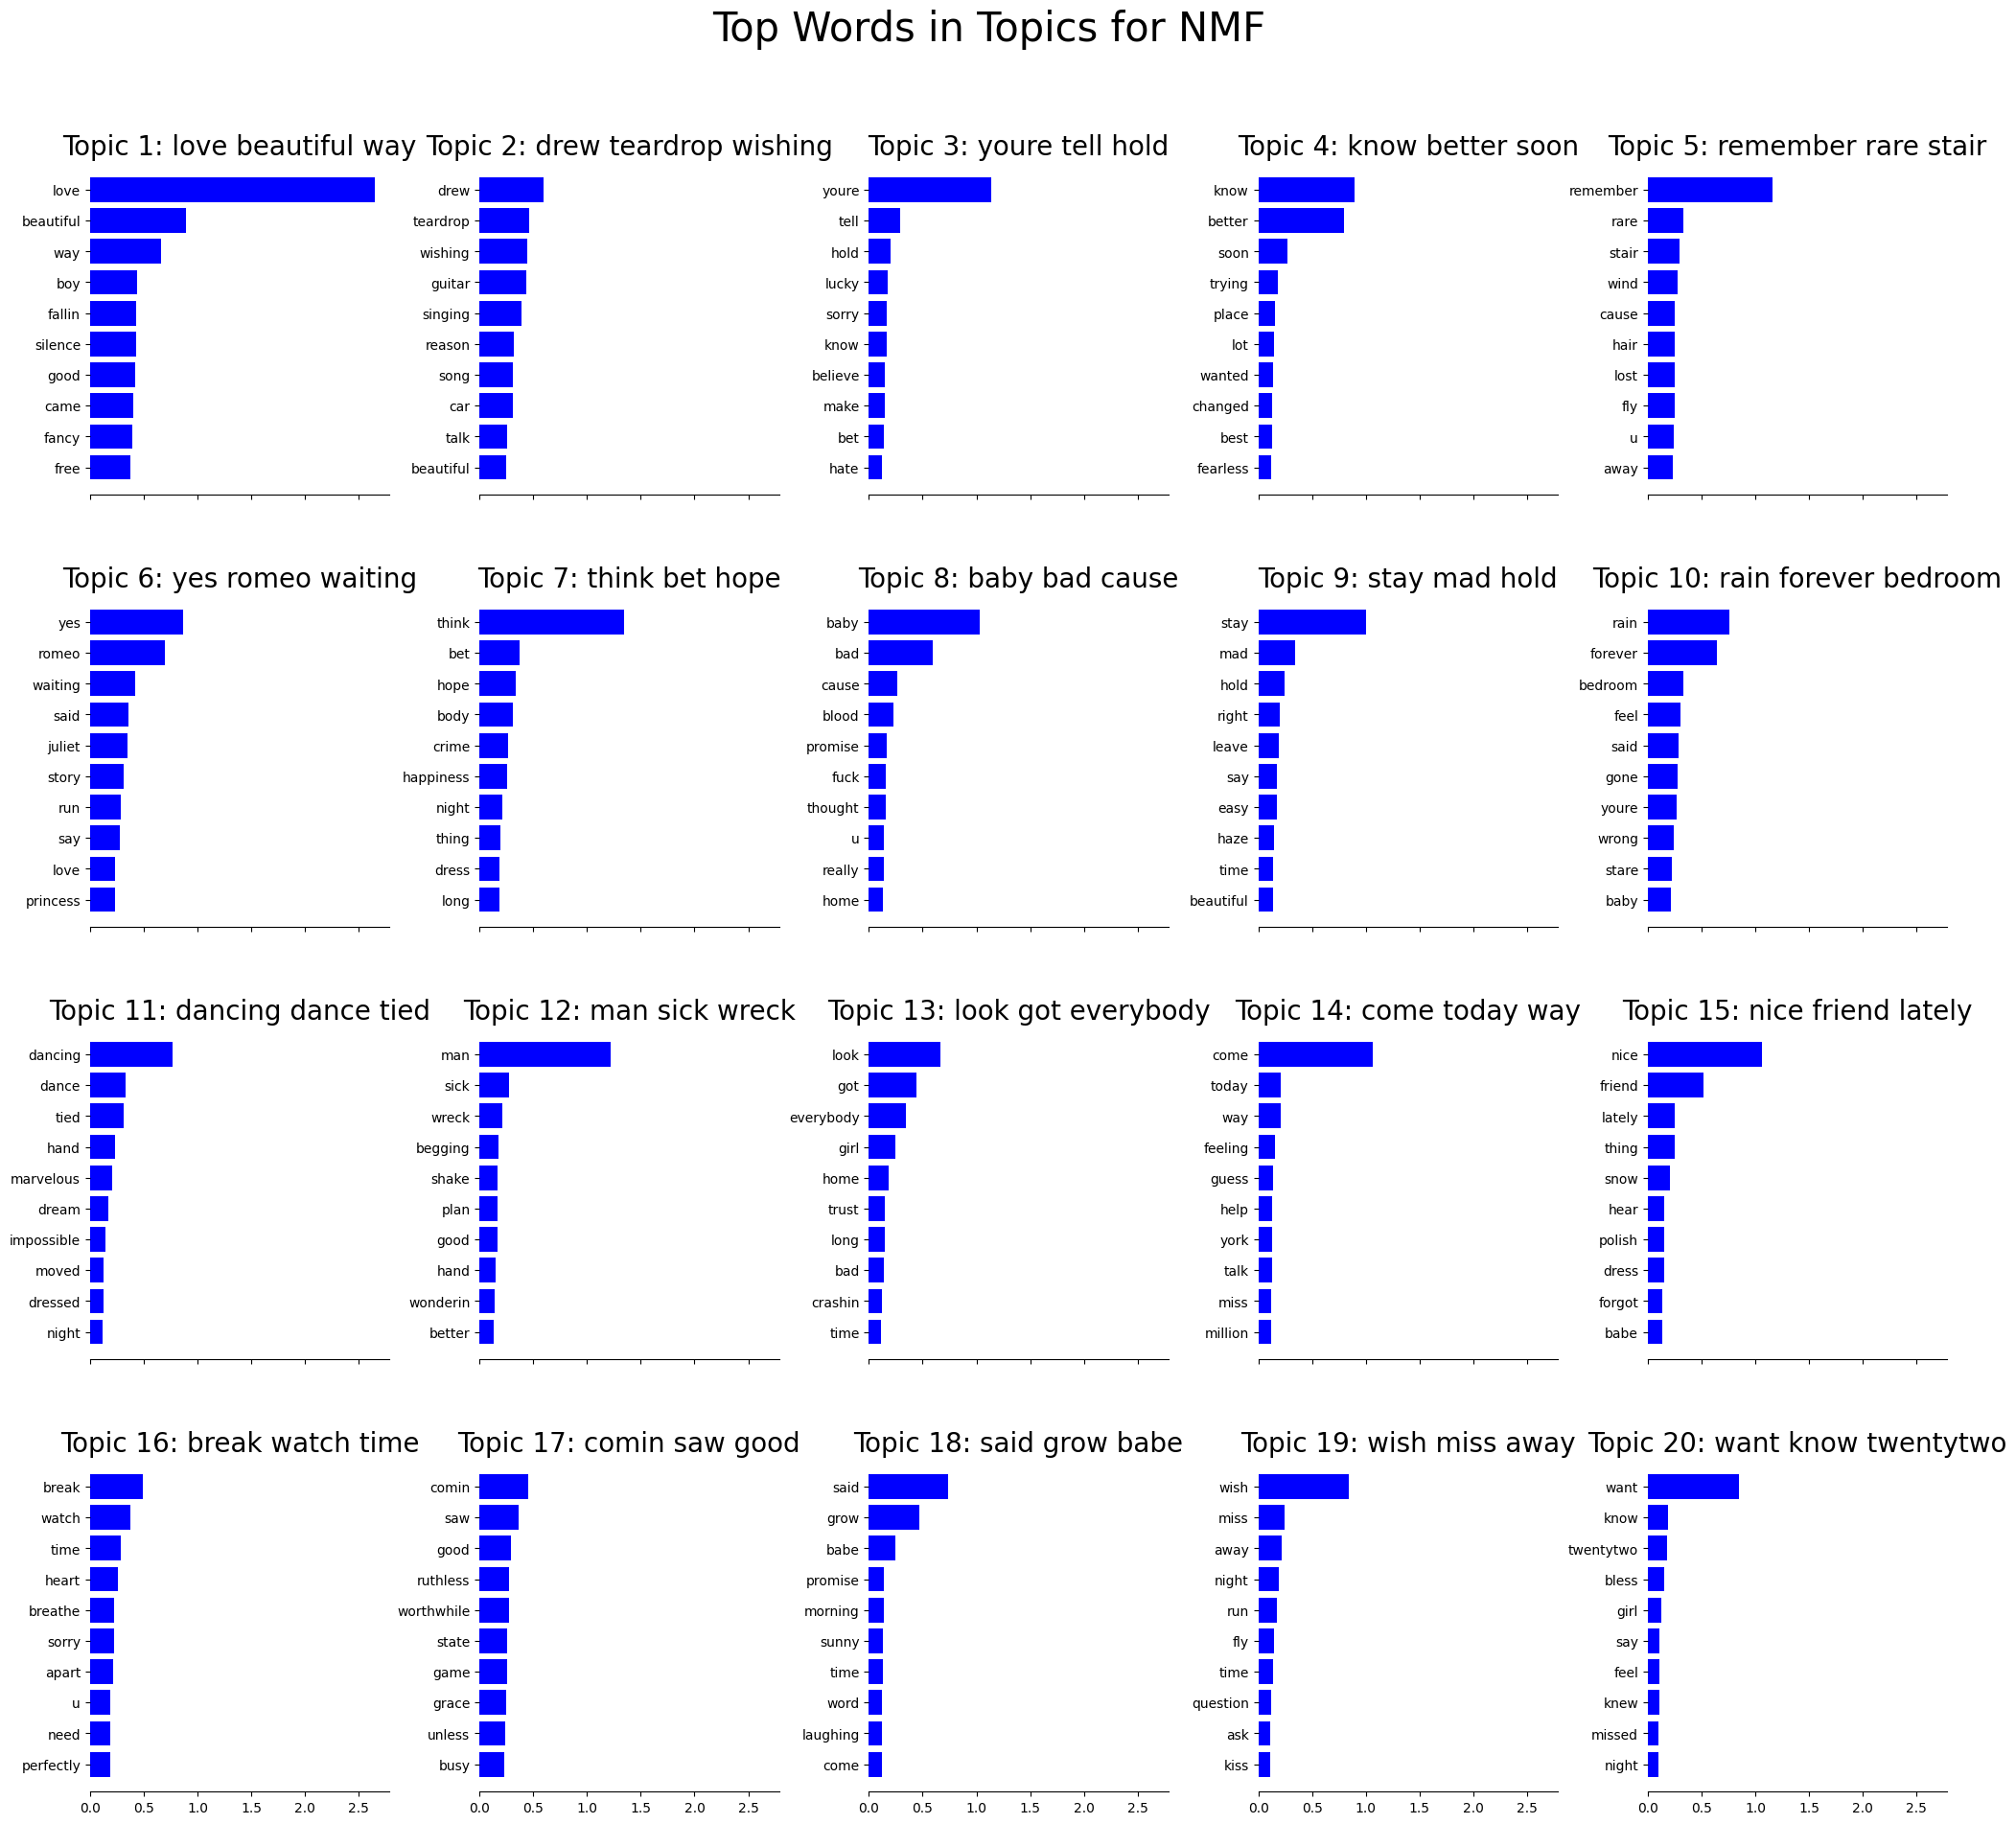

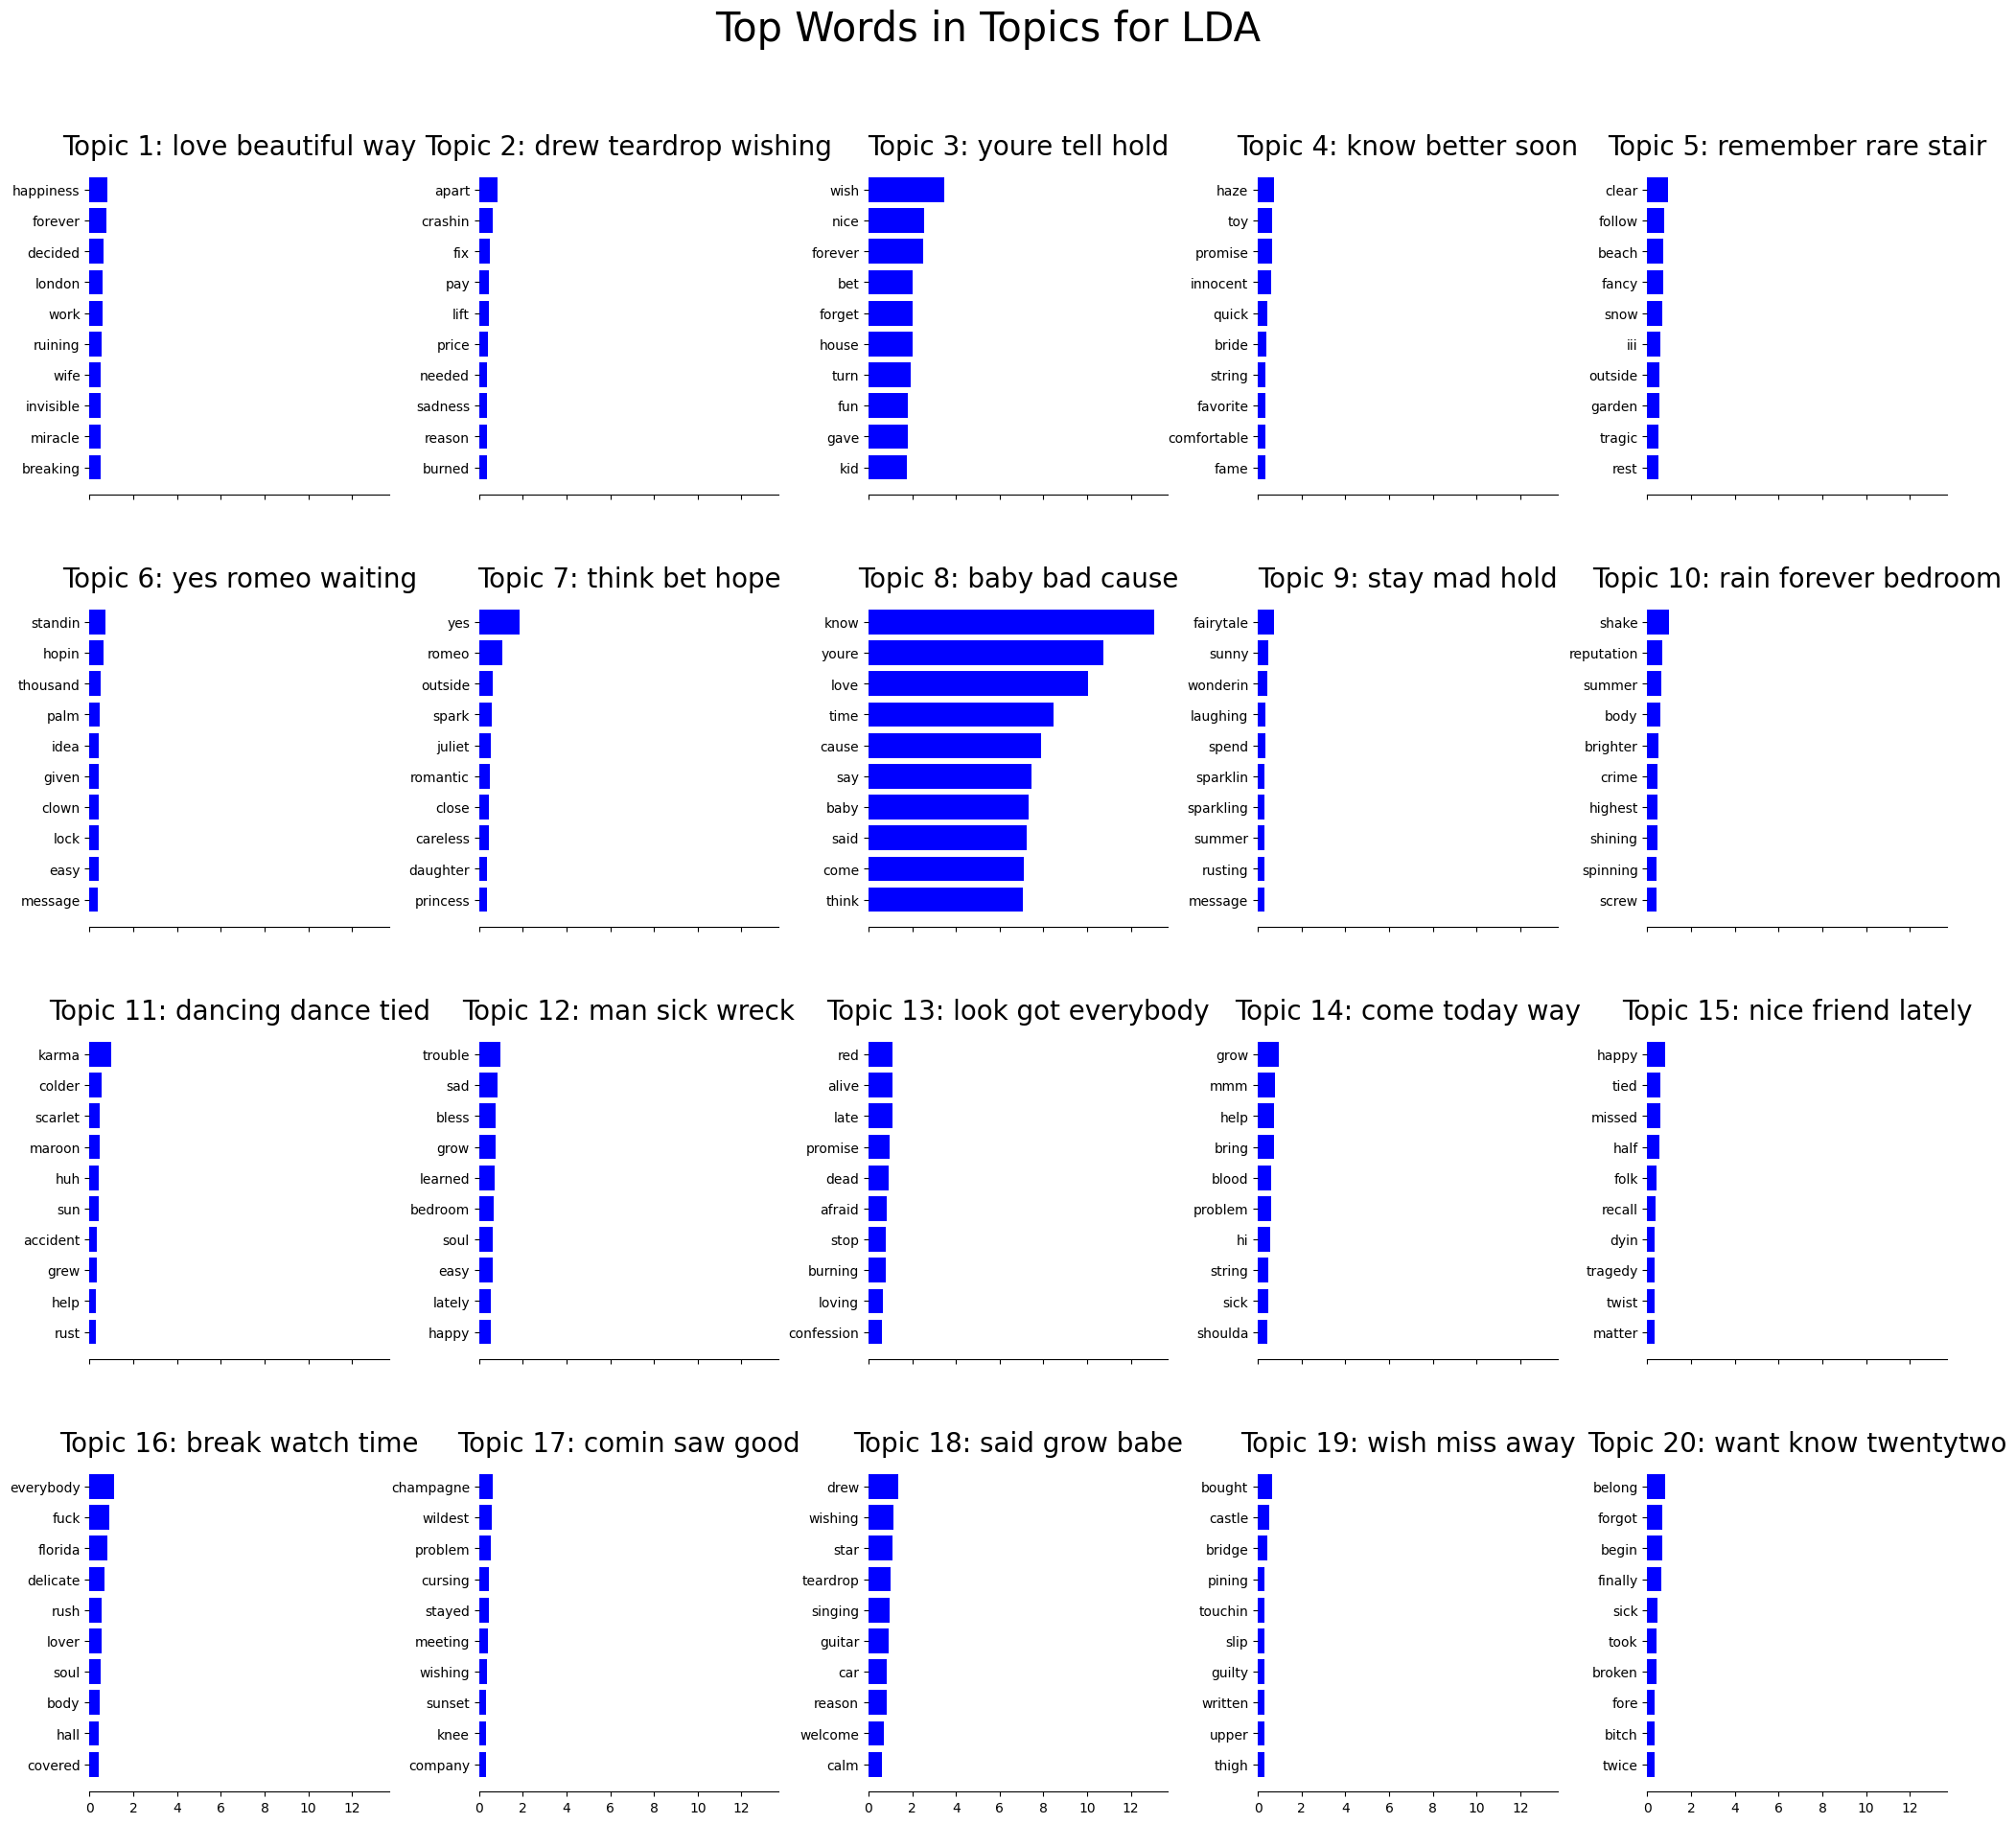

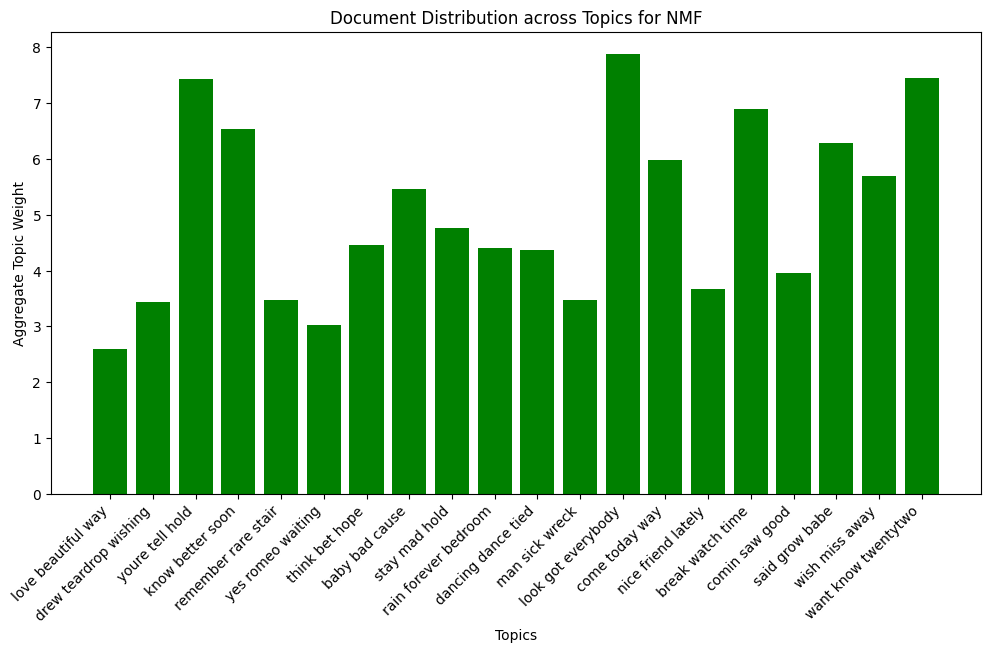

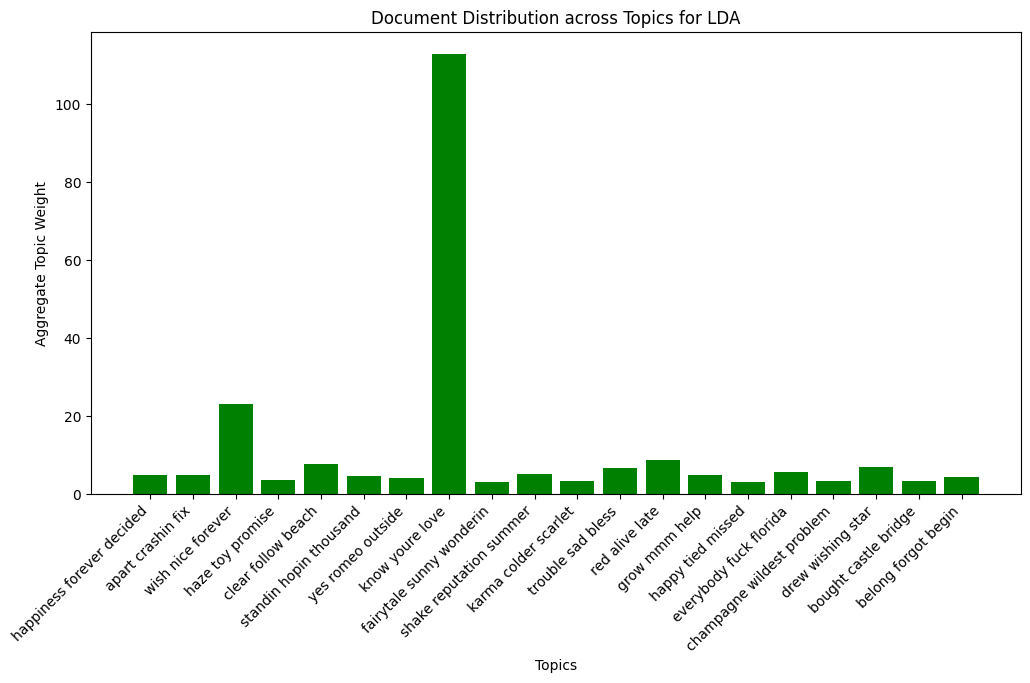

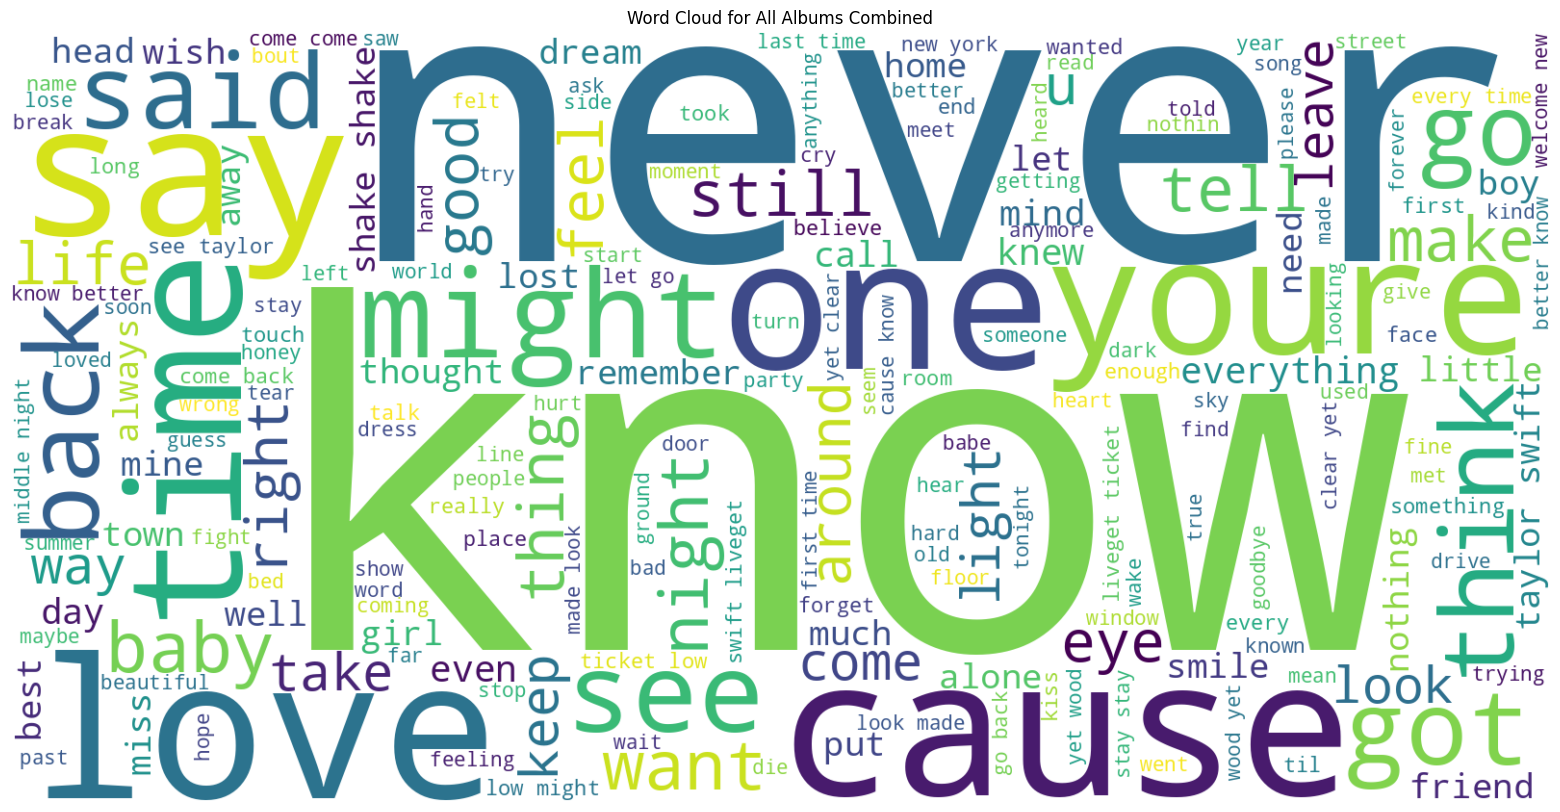

In [7]:
# Topic Modeling - NMF
nmf_model = NMF(n_components=20, max_iter=300, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=20, max_iter=300, learning_method='batch', random_state=0)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Get the feature names (terms) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to generate initial topic names using top words
def generate_topic_name(topic, feature_names, n_top_words=3):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_name = " ".join(top_words)
    return topic_name

# Generate initial topic names
nmf_topic_names = [generate_topic_name(topic, tfidf_feature_names, 3) for topic in nmf_model.components_]
lda_topic_names = [generate_topic_name(topic, tfidf_feature_names, 3) for topic in lda_model.components_]

# Refine topic names manually or using a predefined mapping
# This is a placeholder for the manual or algorithmic refinement process
# For example, you could use a dictionary mapping initial names to refined names
refined_topic_names = {
    "love life heart": "Love and Relationships",
    "time world life": "Philosophy and Life",
    "night moon dark": "Night and Darkness",
    # ... add all topic refinements here
}

# Apply the refined topic names
nmf_topic_names = [refined_topic_names.get(name, name) for name in nmf_topic_names]
lda_topic_names = [refined_topic_names.get(name, name) for name in lda_topic_names]

for idx, topic_name in enumerate(nmf_topic_names):
    print(f"Topic {idx+1} (NMF): {topic_name}")

for idx, topic_name in enumerate(lda_topic_names):
    print(f"Topic {idx+1} (LDA): {topic_name}")

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title, n_cols=5):
    n_topics = len(model.components_)
    n_rows = (n_topics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}: {nmf_topic_names[topic_idx]}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    fig.suptitle(title, fontsize=30)
    plt.show()

plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, topic_names, title):
    topic_distribution = np.sum(model_output, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_names, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_document_topics(nmf_topics, nmf_topic_names, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, lda_topic_names, 'Document Distribution across Topics for LDA')

# Word Cloud Visualization for all topics combined
all_lyrics = ' '.join(merged_df['processed_lyrics'])
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(all_lyrics)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for All Albums Combined')
plt.show()

# Analyze theme variation across different albums
merged_df_nmf = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(nmf_topics, columns=nmf_topic_names)], axis=1)
merged_df_lda = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(lda_topics, columns=lda_topic_names)], axis=1)

# Ensure only numeric columns are considered
numeric_columns_nmf = merged_df_nmf.select_dtypes(include=[np.number]).columns
numeric_columns_lda = merged_df_lda.select_dtypes(include=[np.number]).columns


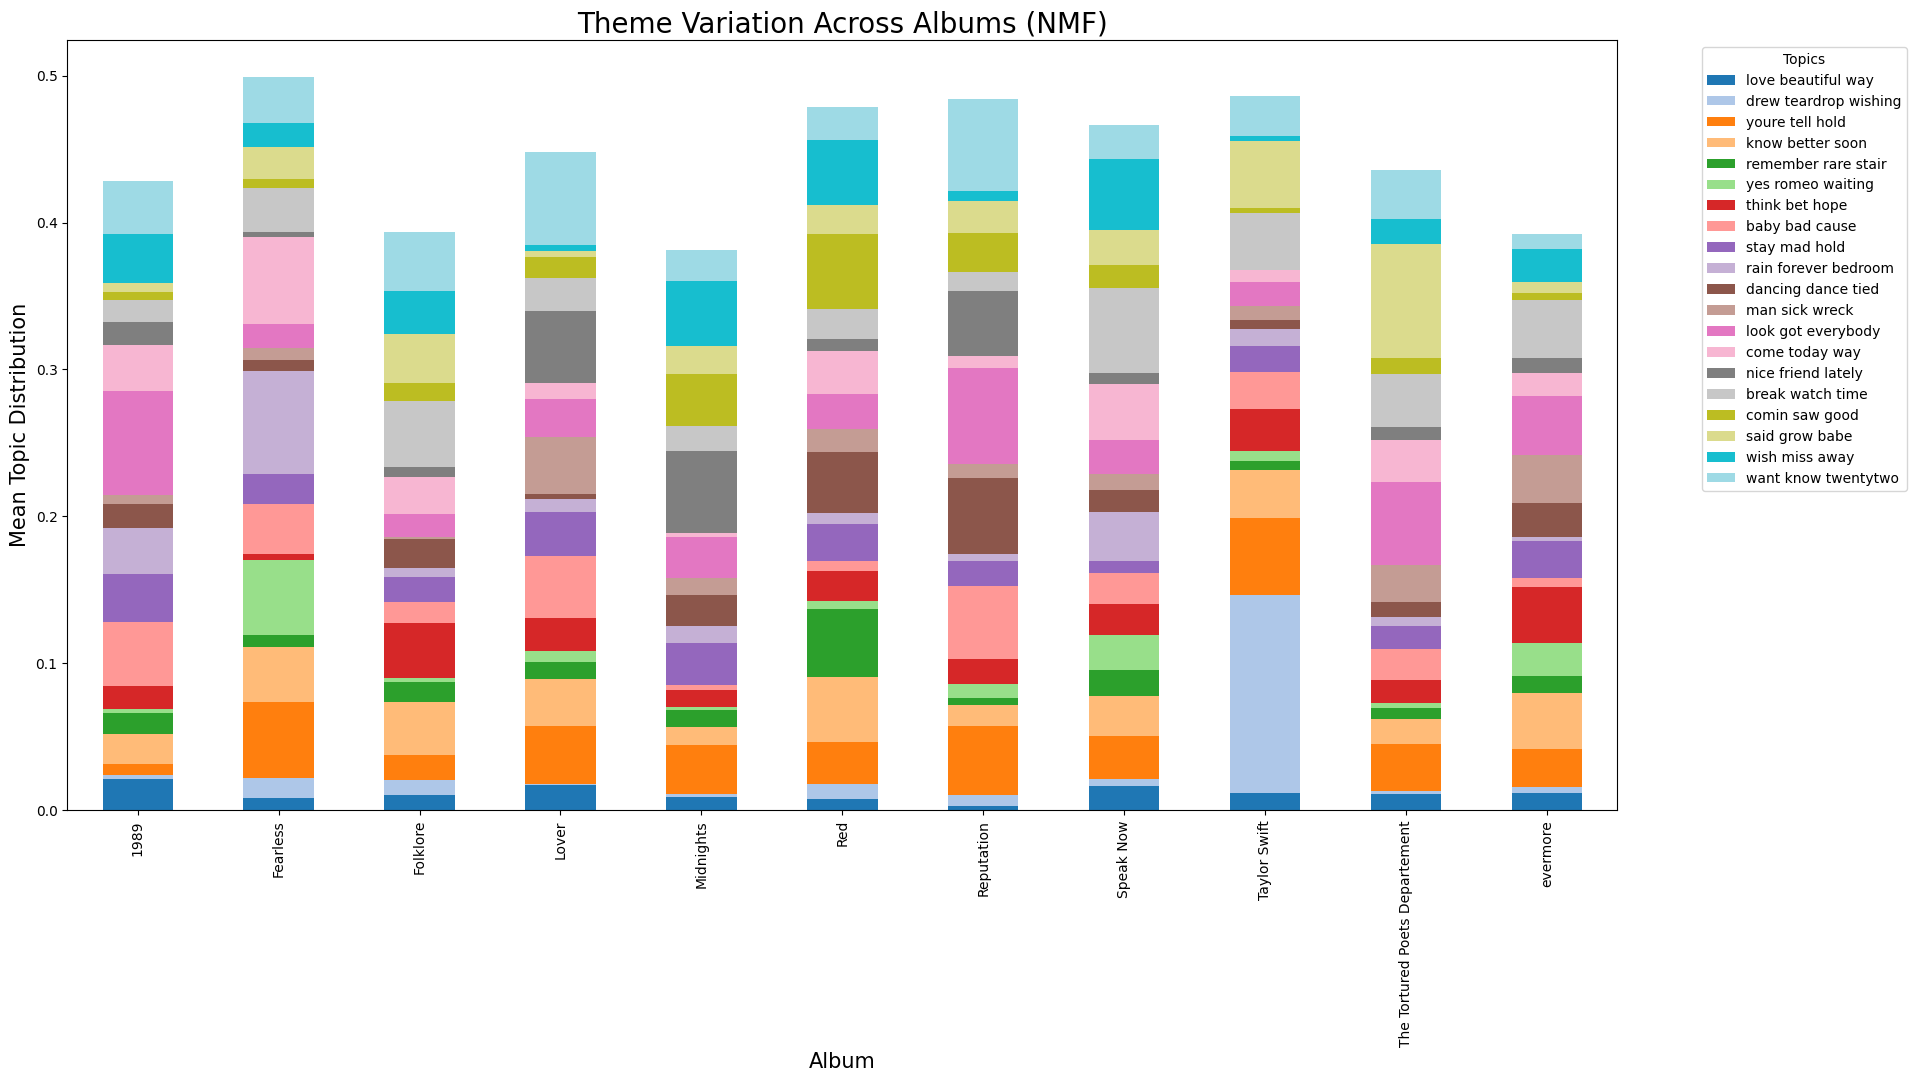

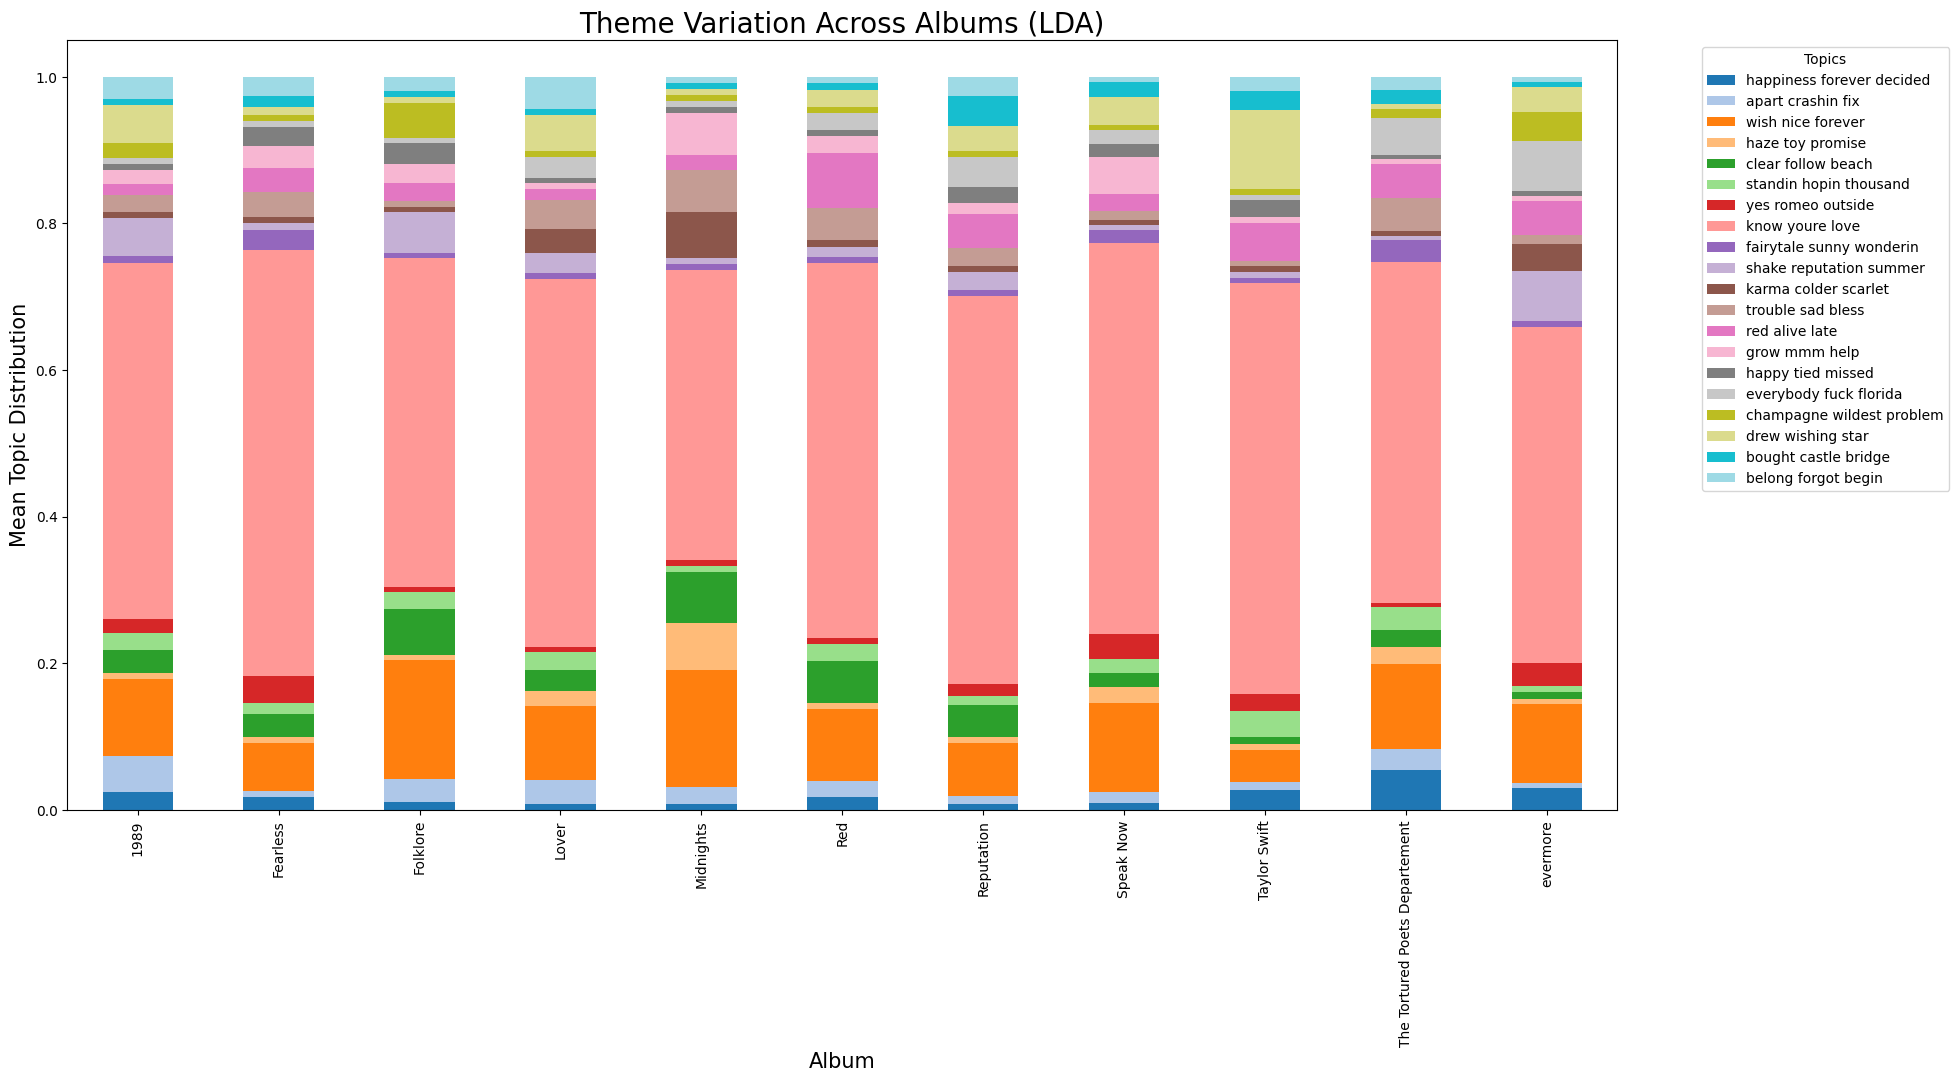

In [8]:
# Group by album and calculate mean topic distribution
album_nmf_distribution = merged_df_nmf.groupby('Album')[numeric_columns_nmf].mean().iloc[:, -20:]
album_lda_distribution = merged_df_lda.groupby('Album')[numeric_columns_lda].mean().iloc[:, -20:]

# Plotting theme variation across albums
def plot_theme_variation(album_distribution, model_name):
    album_distribution.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='tab20')
    plt.title(f'Theme Variation Across Albums ({model_name})', fontsize=20)
    plt.xlabel('Album', fontsize=15)
    plt.ylabel('Mean Topic Distribution', fontsize=15)
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_theme_variation(album_nmf_distribution, 'NMF')
plot_theme_variation(album_lda_distribution, 'LDA')

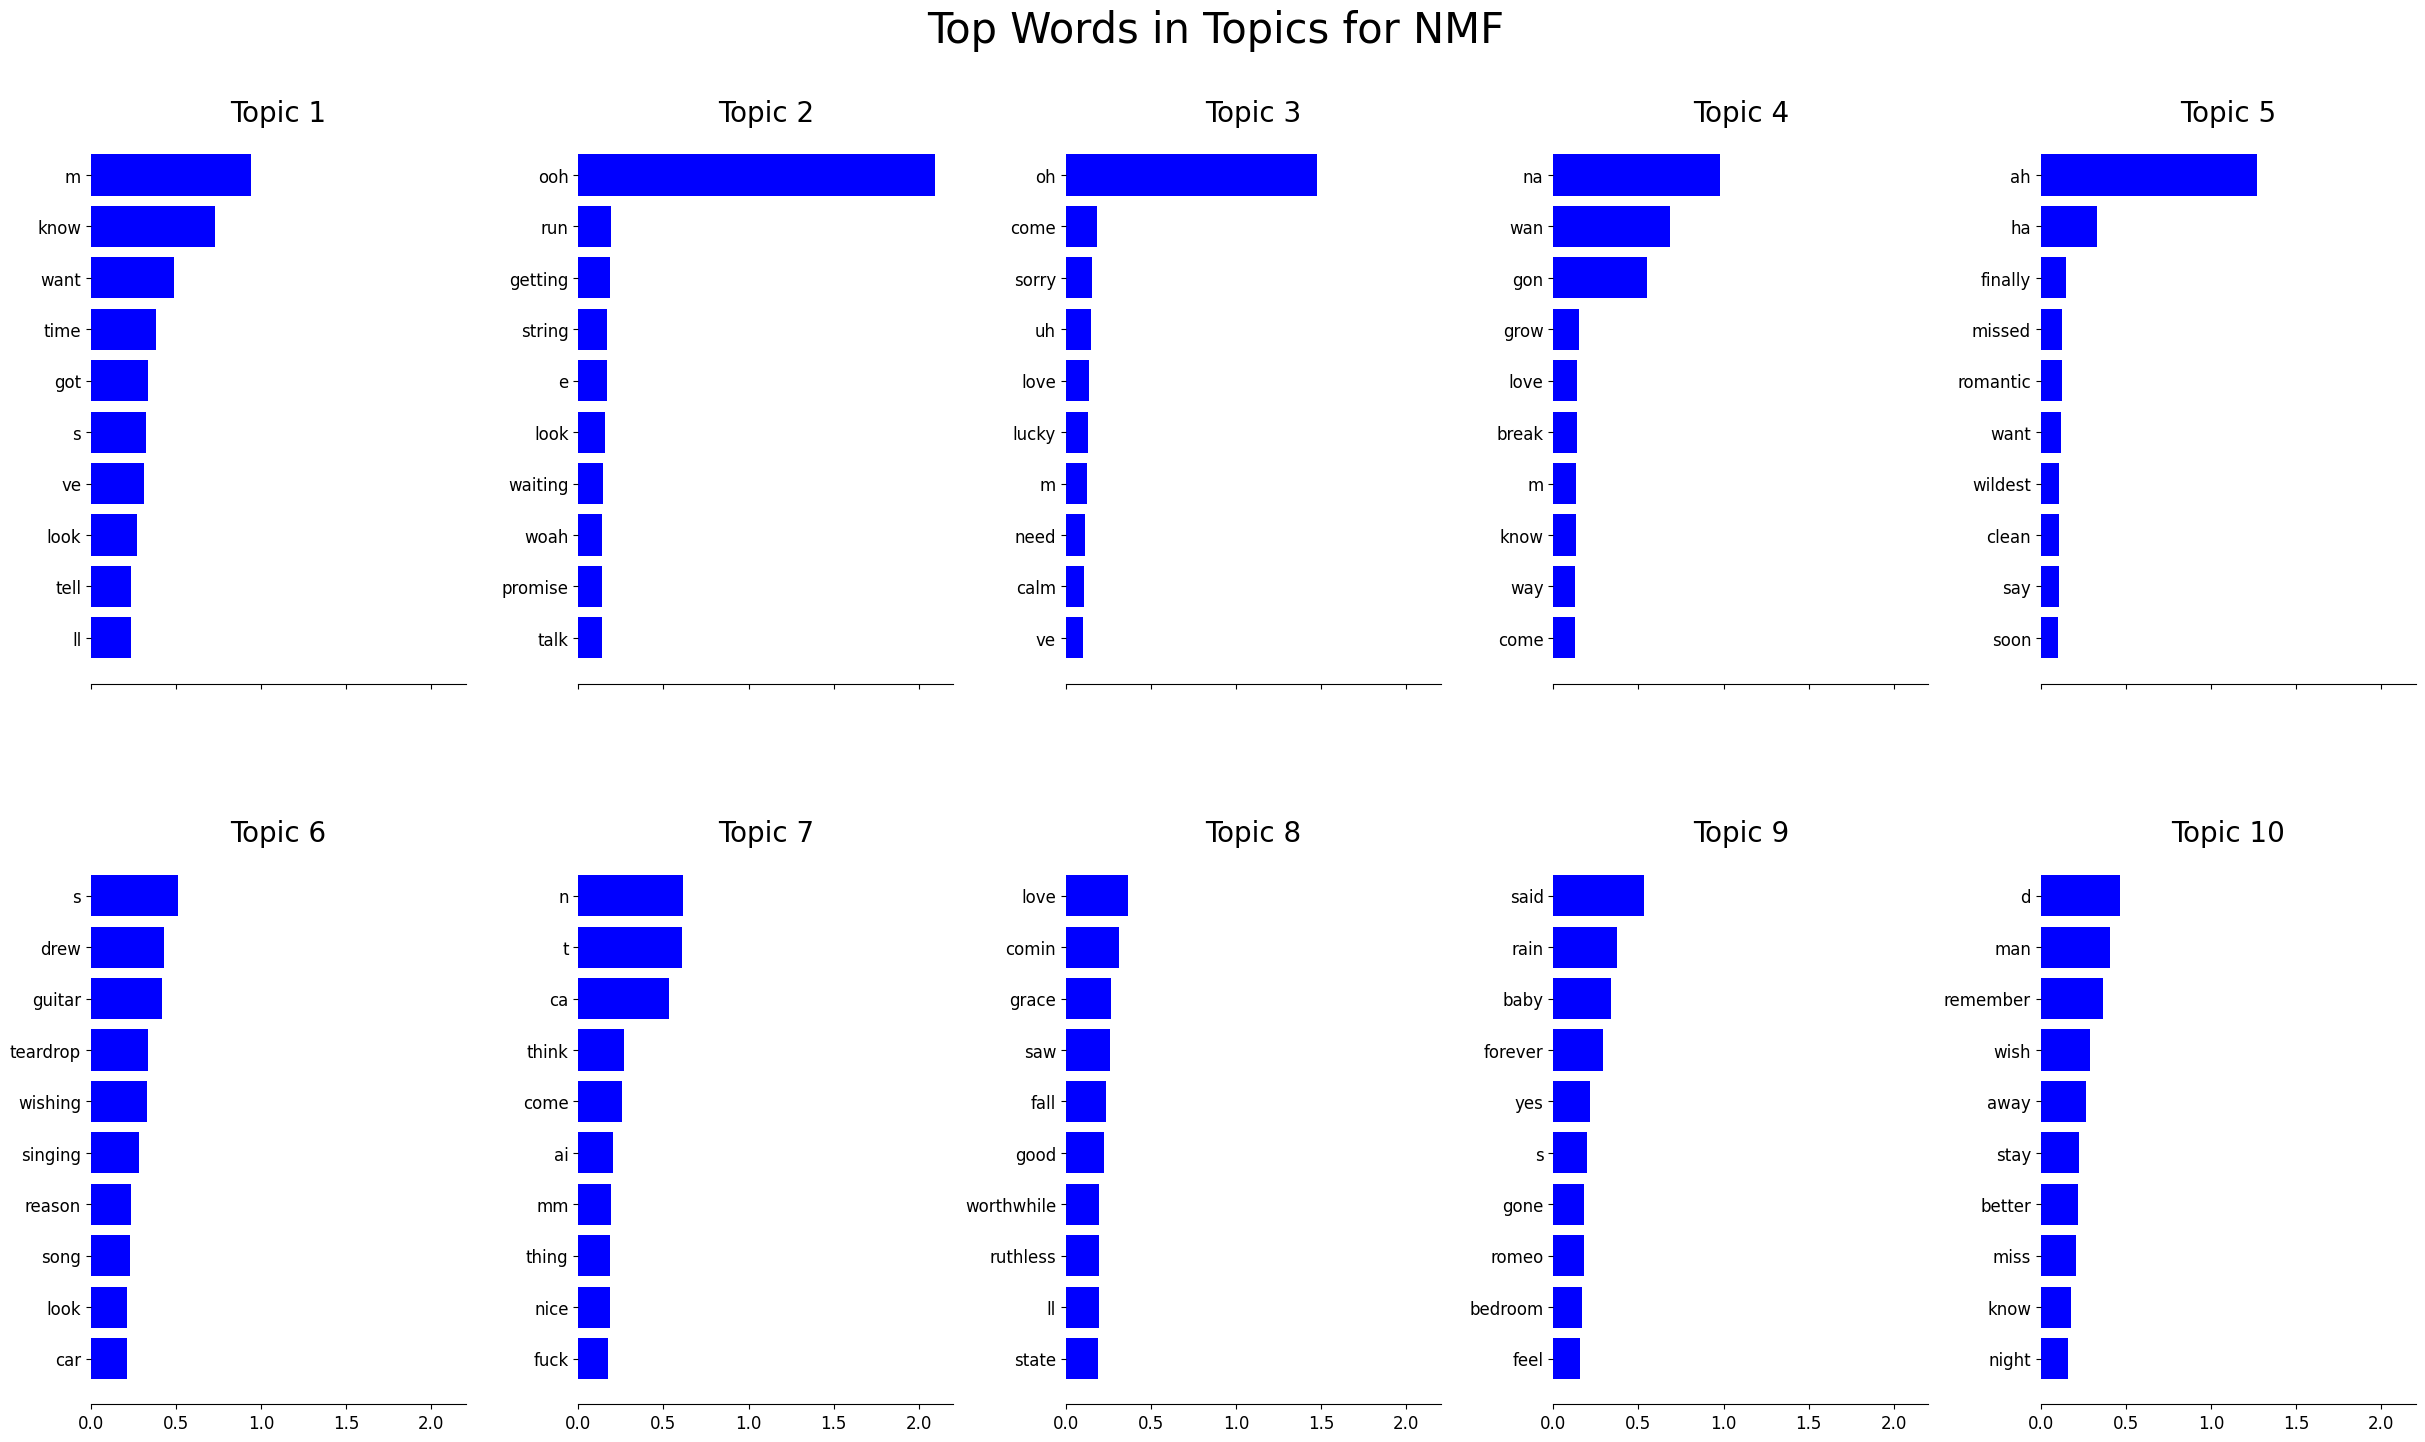

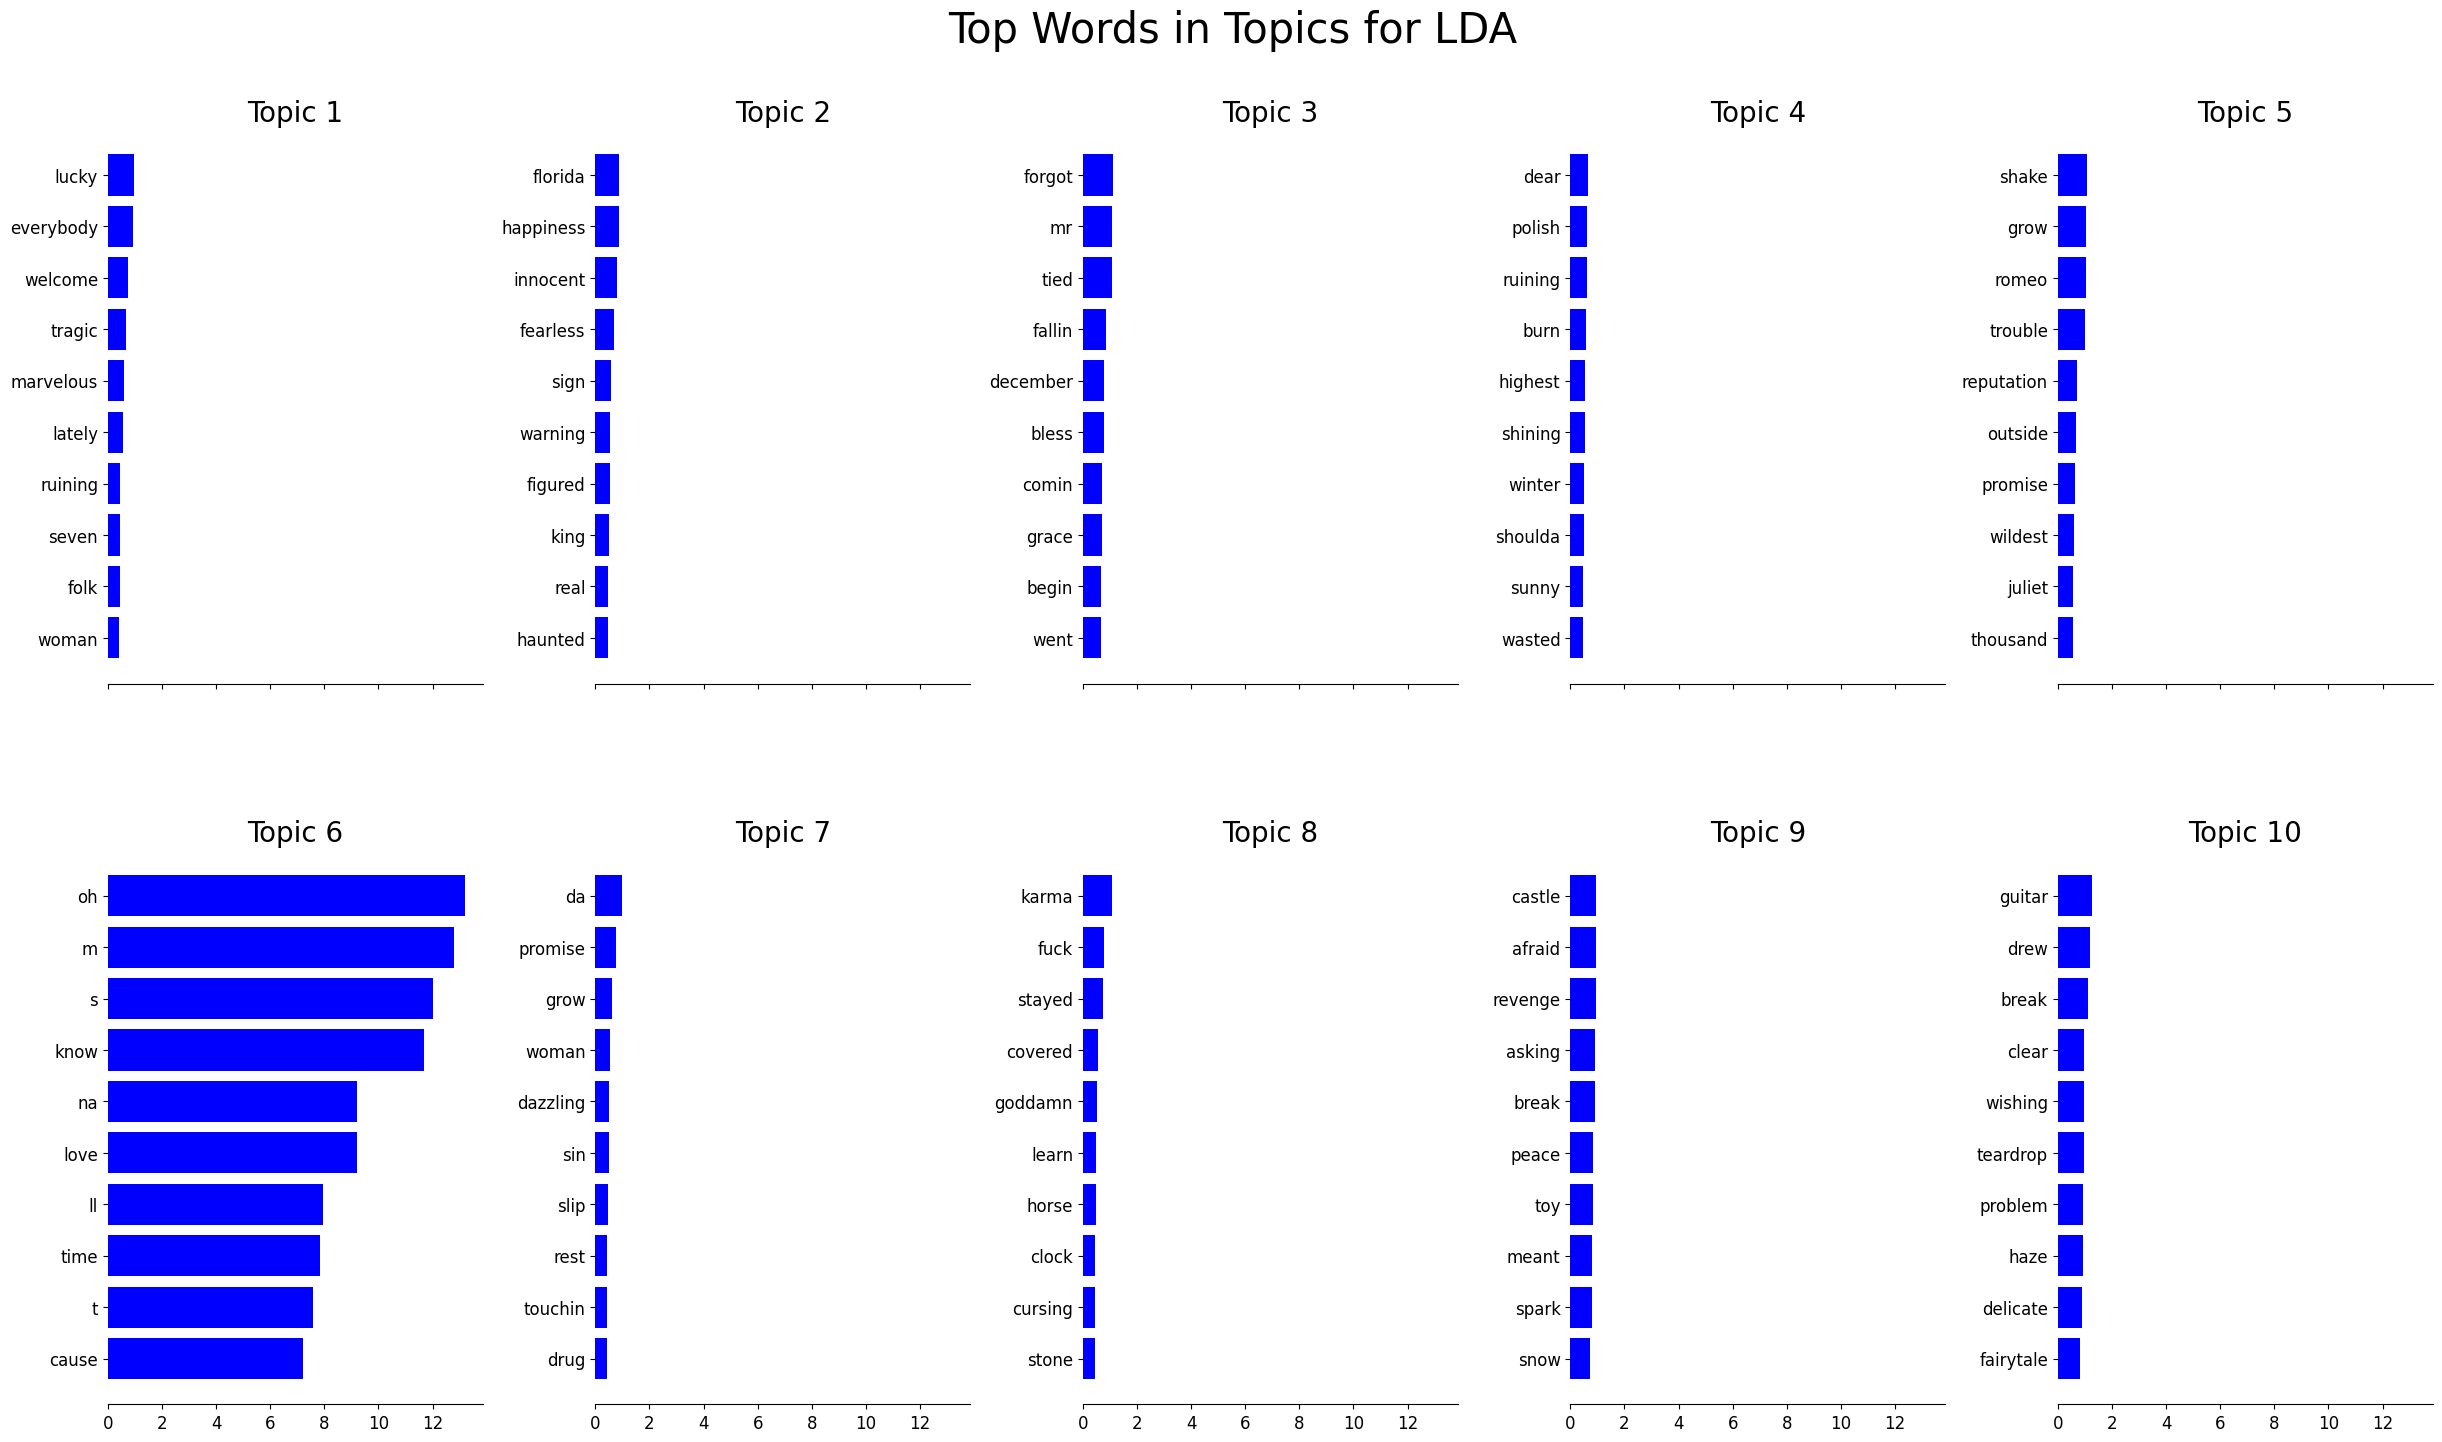

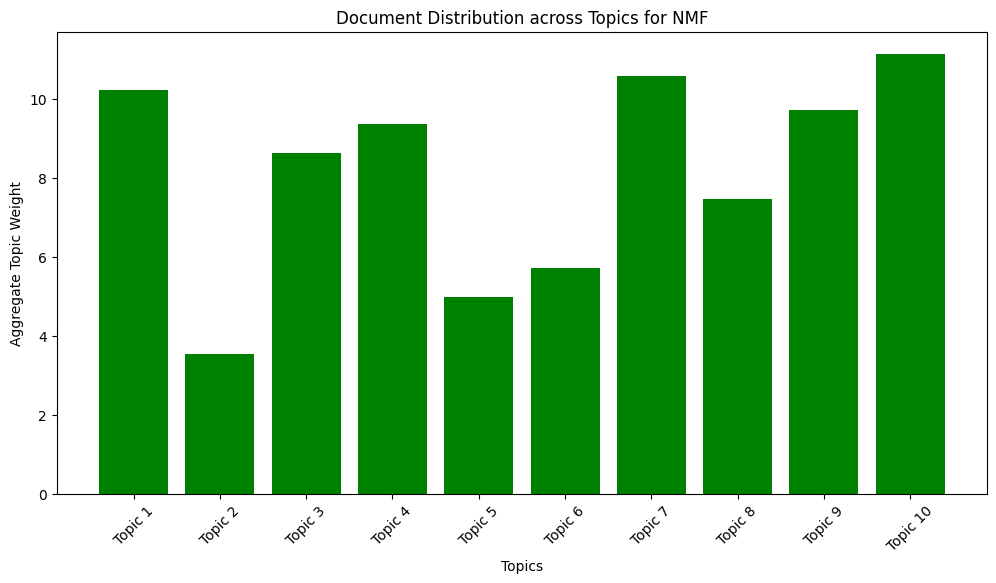

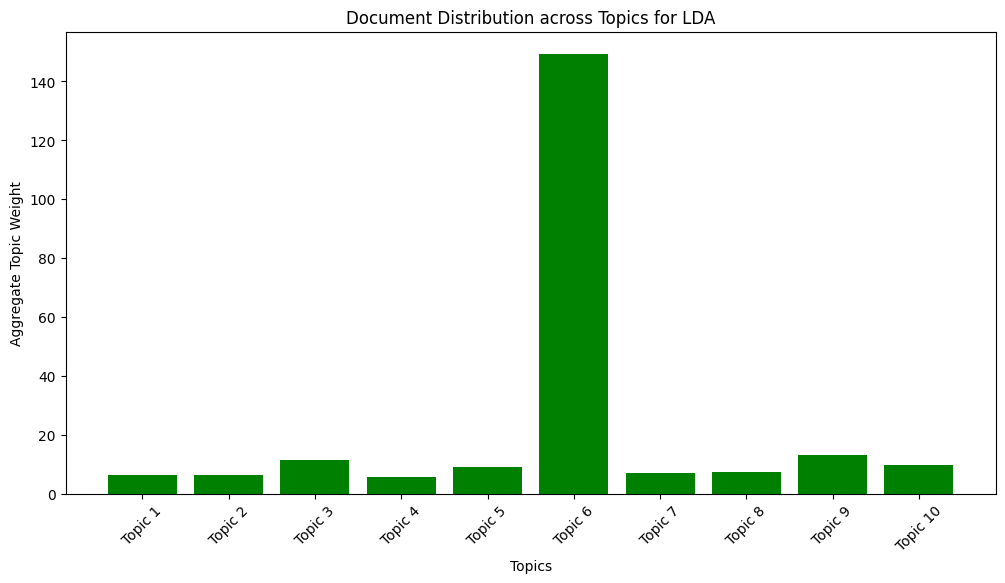

In [7]:
# Topic Modeling - NMF
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_df)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_df)

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=30)
    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    plt.show()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, title):
    # Aggregate the topic distribution for visualization
    topic_distribution = np.sum(model_output, axis=0)
    topic_indices = [f"Topic {i+1}" for i in range(len(topic_distribution))]
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_indices, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_document_topics(nmf_topics, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, 'Document Distribution across Topics for LDA')


Topic 1 (NMF): love beautiful
Topic 2 (NMF): drew teardrop
Topic 3 (NMF): youre tell
Topic 4 (NMF): know better
Topic 5 (NMF): remember rare
Topic 6 (NMF): yes romeo
Topic 7 (NMF): think bet
Topic 8 (NMF): baby bad
Topic 9 (NMF): stay mad
Topic 10 (NMF): rain forever
Topic 11 (NMF): dancing dance
Topic 12 (NMF): man sick
Topic 13 (NMF): look got
Topic 14 (NMF): come today
Topic 15 (NMF): nice friend
Topic 16 (NMF): break watch
Topic 17 (NMF): comin saw
Topic 18 (NMF): said grow
Topic 19 (NMF): wish miss
Topic 20 (NMF): want know
Topic 1 (LDA): happiness forever
Topic 2 (LDA): apart crashin
Topic 3 (LDA): wish nice
Topic 4 (LDA): haze toy
Topic 5 (LDA): clear follow
Topic 6 (LDA): standin hopin
Topic 7 (LDA): yes romeo
Topic 8 (LDA): know youre
Topic 9 (LDA): fairytale sunny
Topic 10 (LDA): shake reputation
Topic 11 (LDA): karma colder
Topic 12 (LDA): trouble sad
Topic 13 (LDA): red alive
Topic 14 (LDA): grow mmm
Topic 15 (LDA): happy tied
Topic 16 (LDA): everybody fuck
Topic 17 (LDA): 

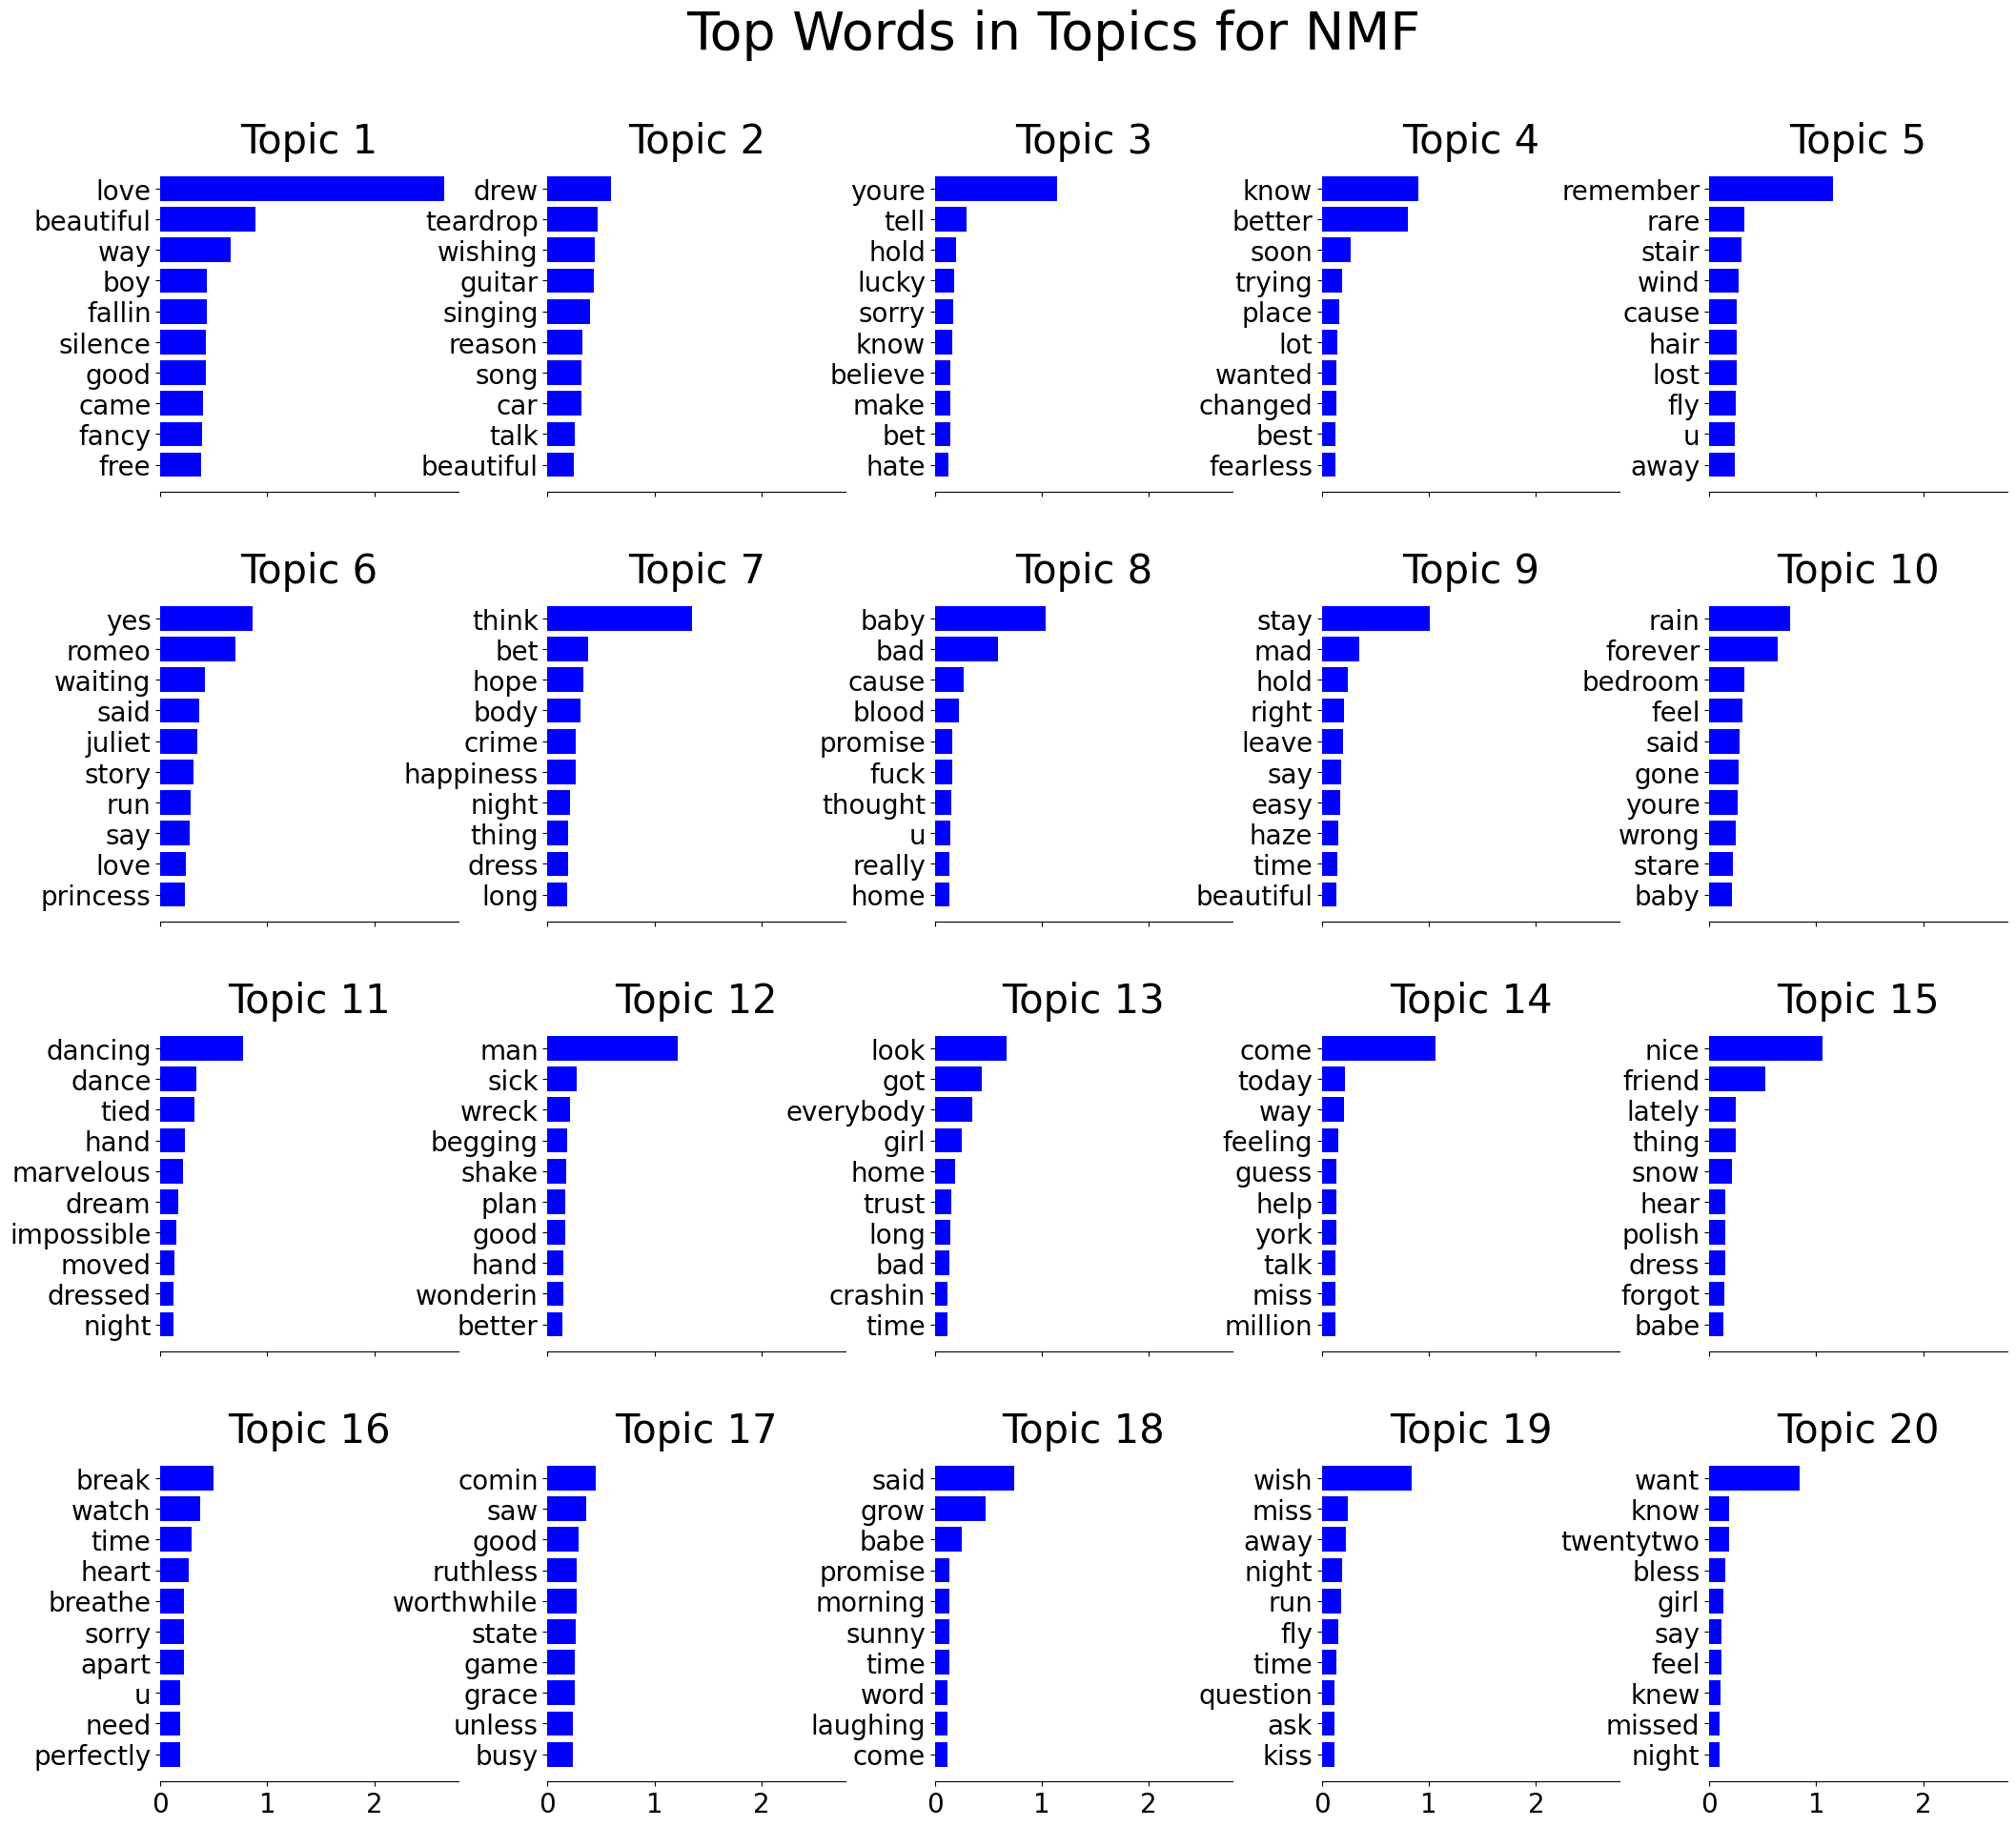

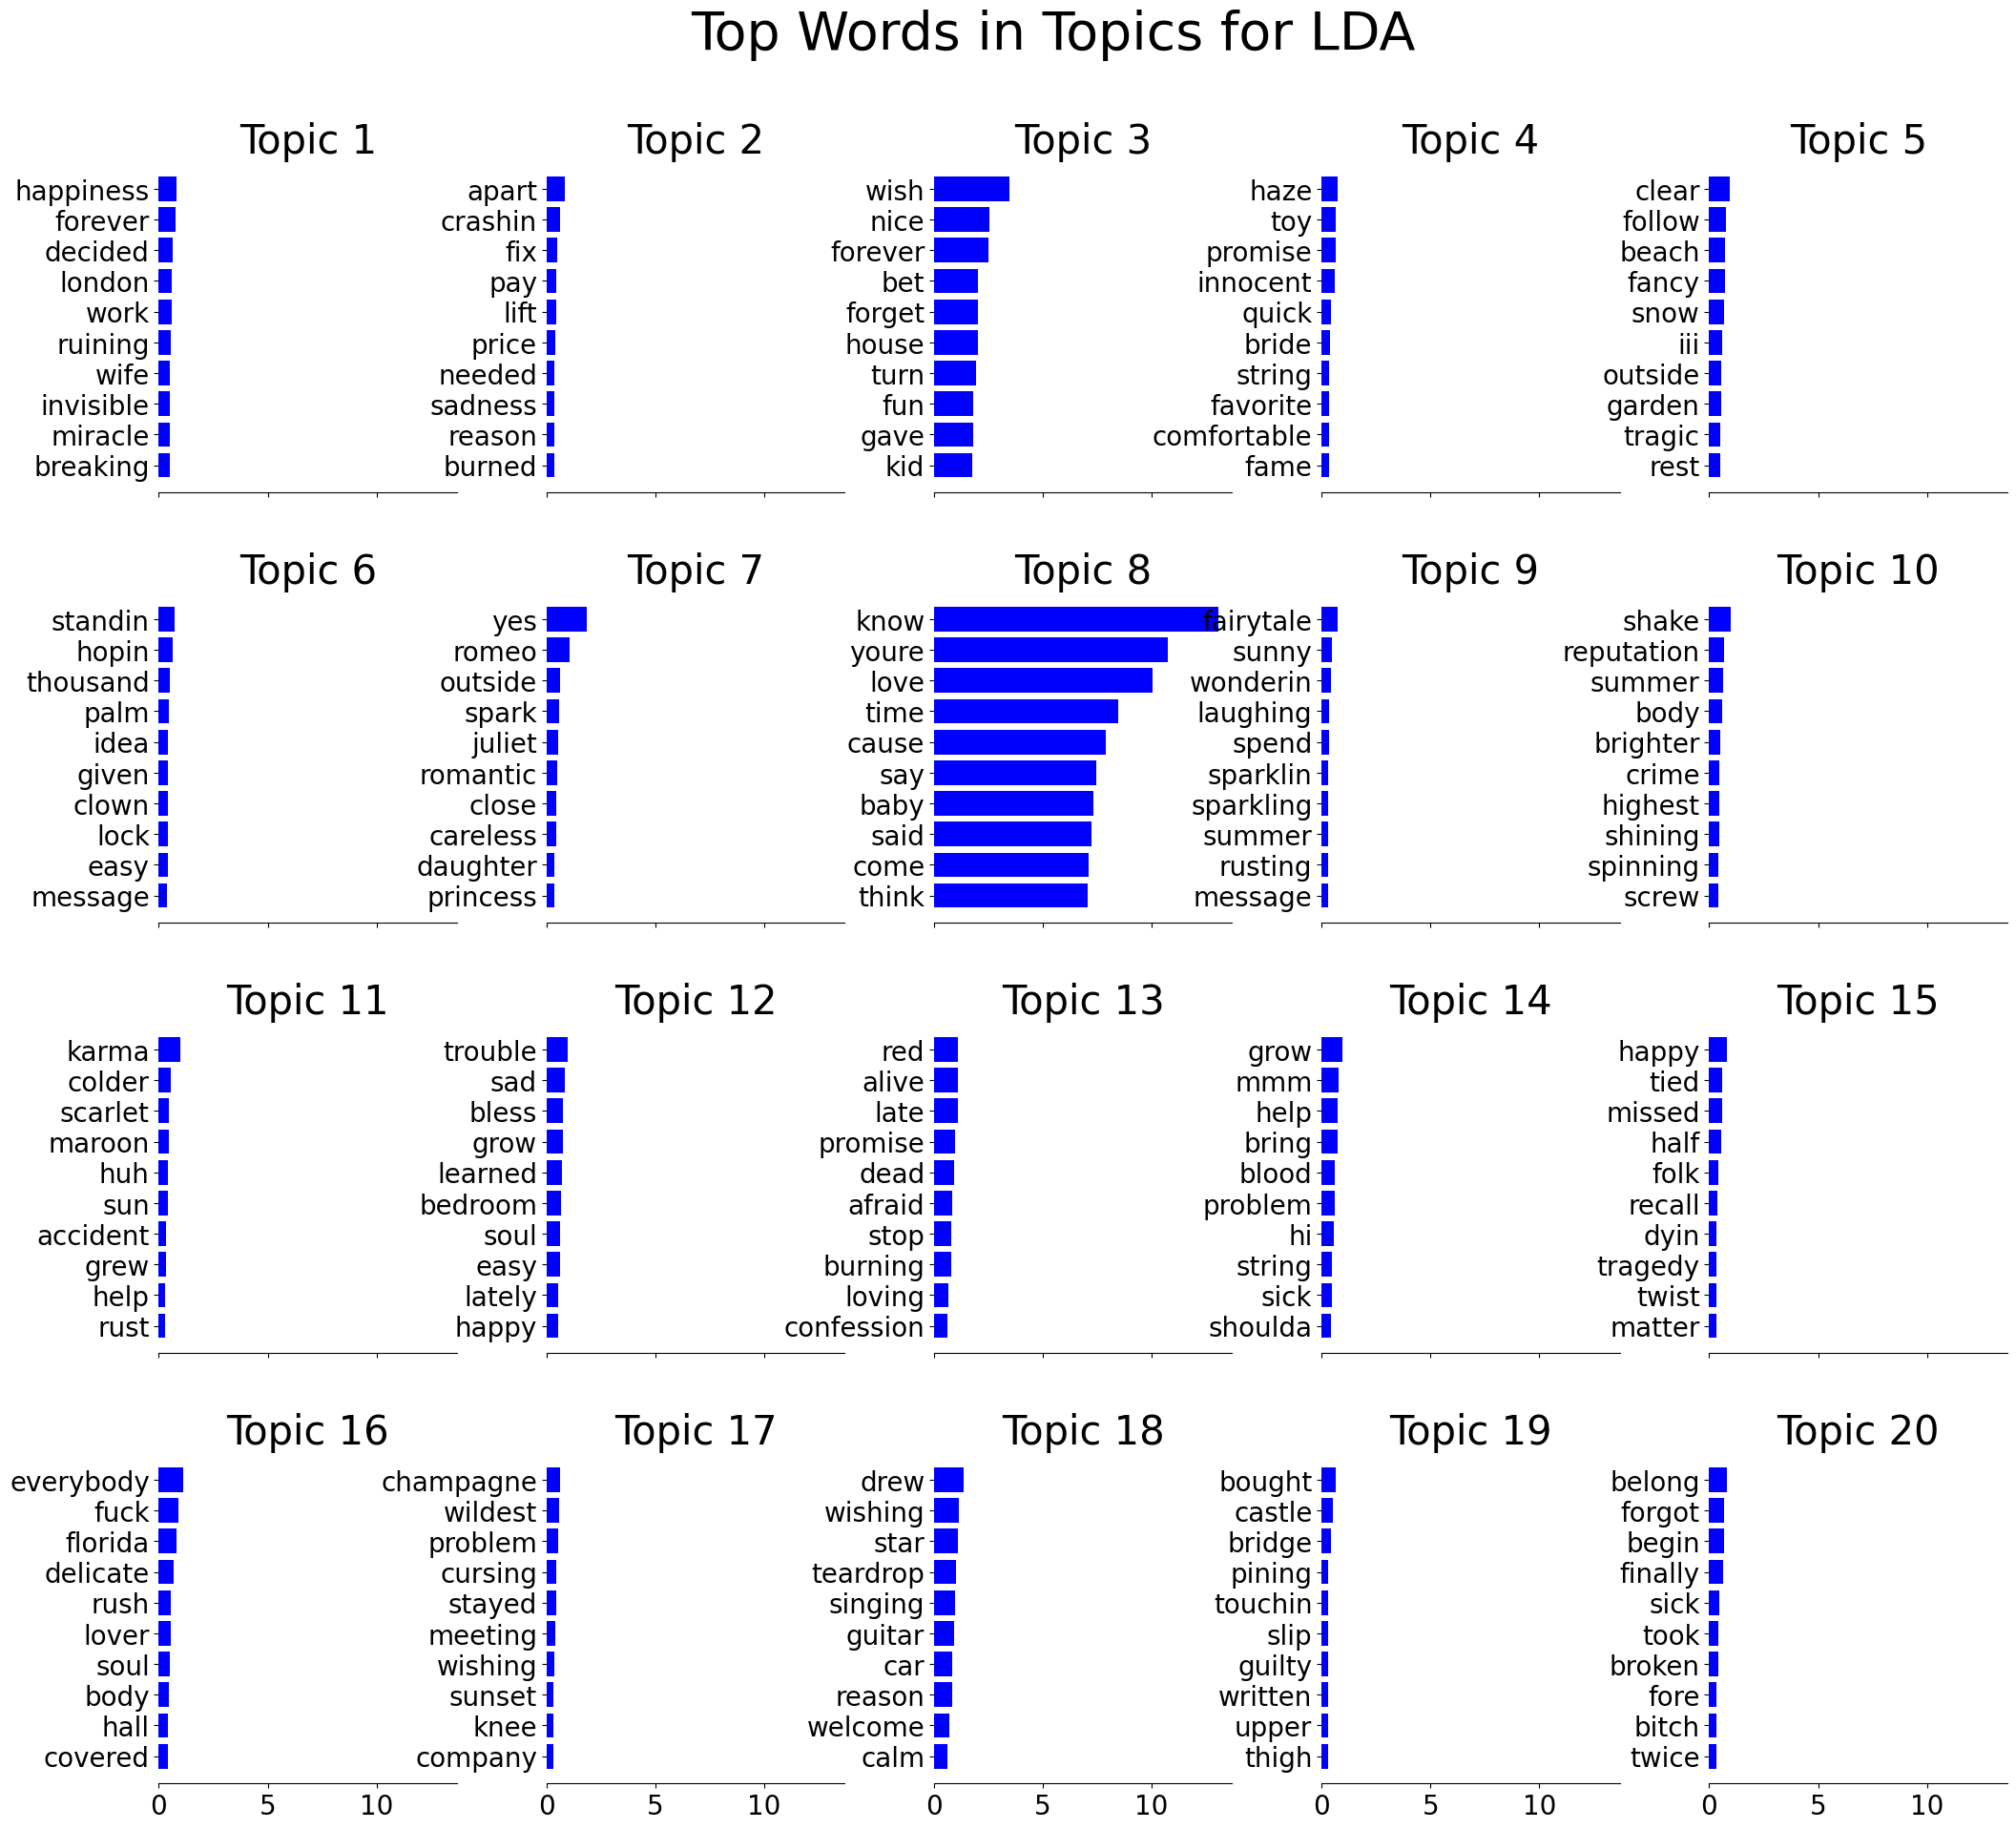

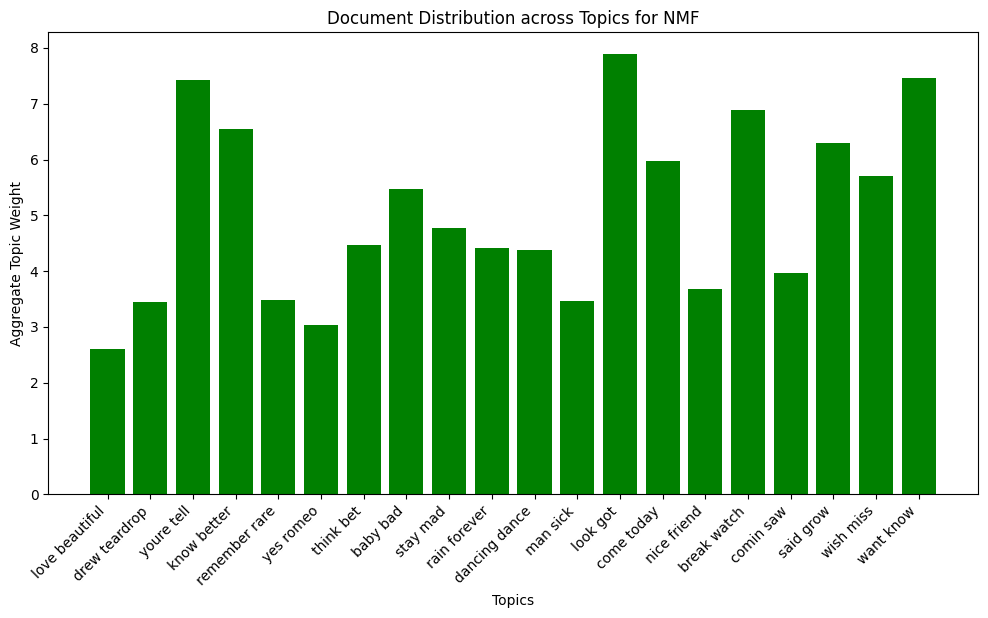

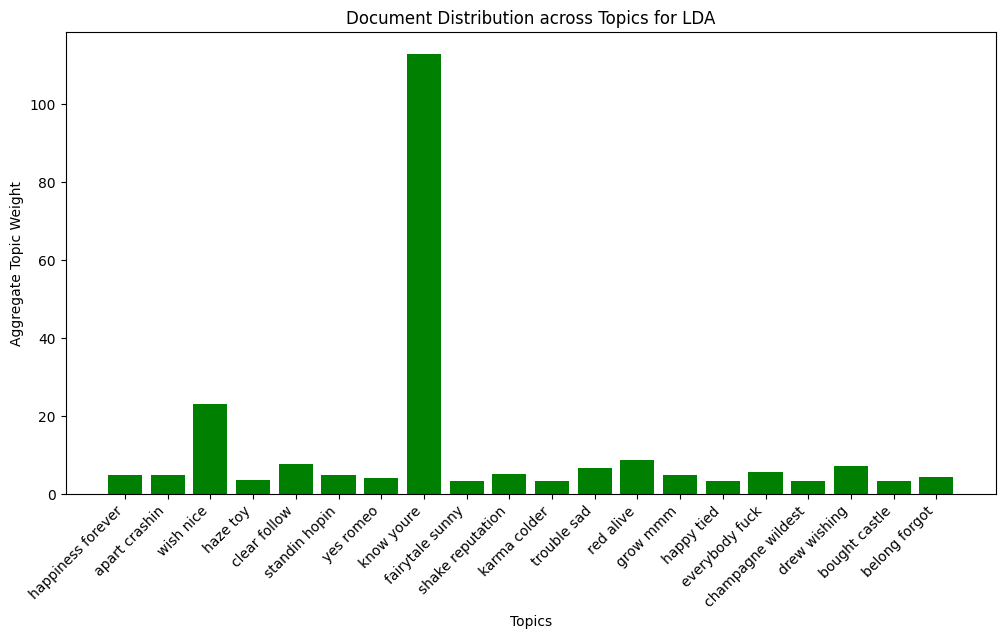

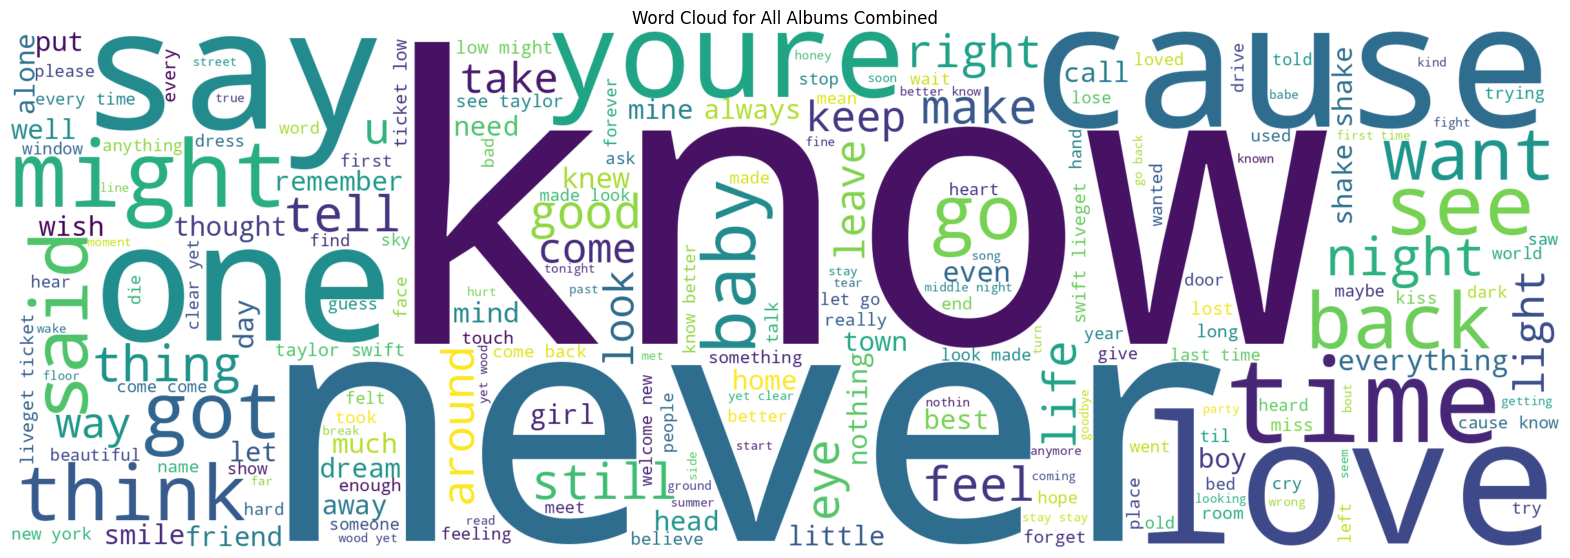

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# Assuming tfidf_matrix and tfidf_vectorizer are already defined and fit
# tfidf_matrix = ...
# tfidf_vectorizer = ...

# Topic Modeling - NMF
nmf_model = NMF(n_components=20, max_iter=300, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=20, max_iter=300, learning_method='batch', random_state=0)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Get the feature names (terms) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to generate topic names using top words
def generate_topic_name(topic, feature_names, n_top_words=2):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    topic_name = " ".join(top_words)
    return topic_name

def get_topic_names(model, feature_names, n_top_words=2):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        topic_name = generate_topic_name(topic, feature_names, n_top_words)
        topic_names.append(topic_name)
    return topic_names

# Generate topic names using the top 2 words
nmf_topic_names = get_topic_names(nmf_model, tfidf_feature_names, 2)
lda_topic_names = get_topic_names(lda_model, tfidf_feature_names, 2)

for idx, topic_name in enumerate(nmf_topic_names):
    print(f"Topic {idx+1} (NMF): {topic_name}")

for idx, topic_name in enumerate(lda_topic_names):
    print(f"Topic {idx+1} (LDA): {topic_name}")

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title, n_cols=5):
    n_topics = len(model.components_)
    n_rows = (n_topics + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    fig.suptitle(title, fontsize=40)
    plt.show()
    
plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, topic_names, title):
    topic_distribution = np.sum(model_output, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_names, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_document_topics(nmf_topics, nmf_topic_names, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, lda_topic_names, 'Document Distribution across Topics for LDA')

# Word Cloud Visualization for all topics combined
all_lyrics = ' '.join(merged_df['processed_lyrics'])
wordcloud = WordCloud(width=2400, height=800, background_color='white').generate(all_lyrics)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for All Albums Combined')
plt.show()


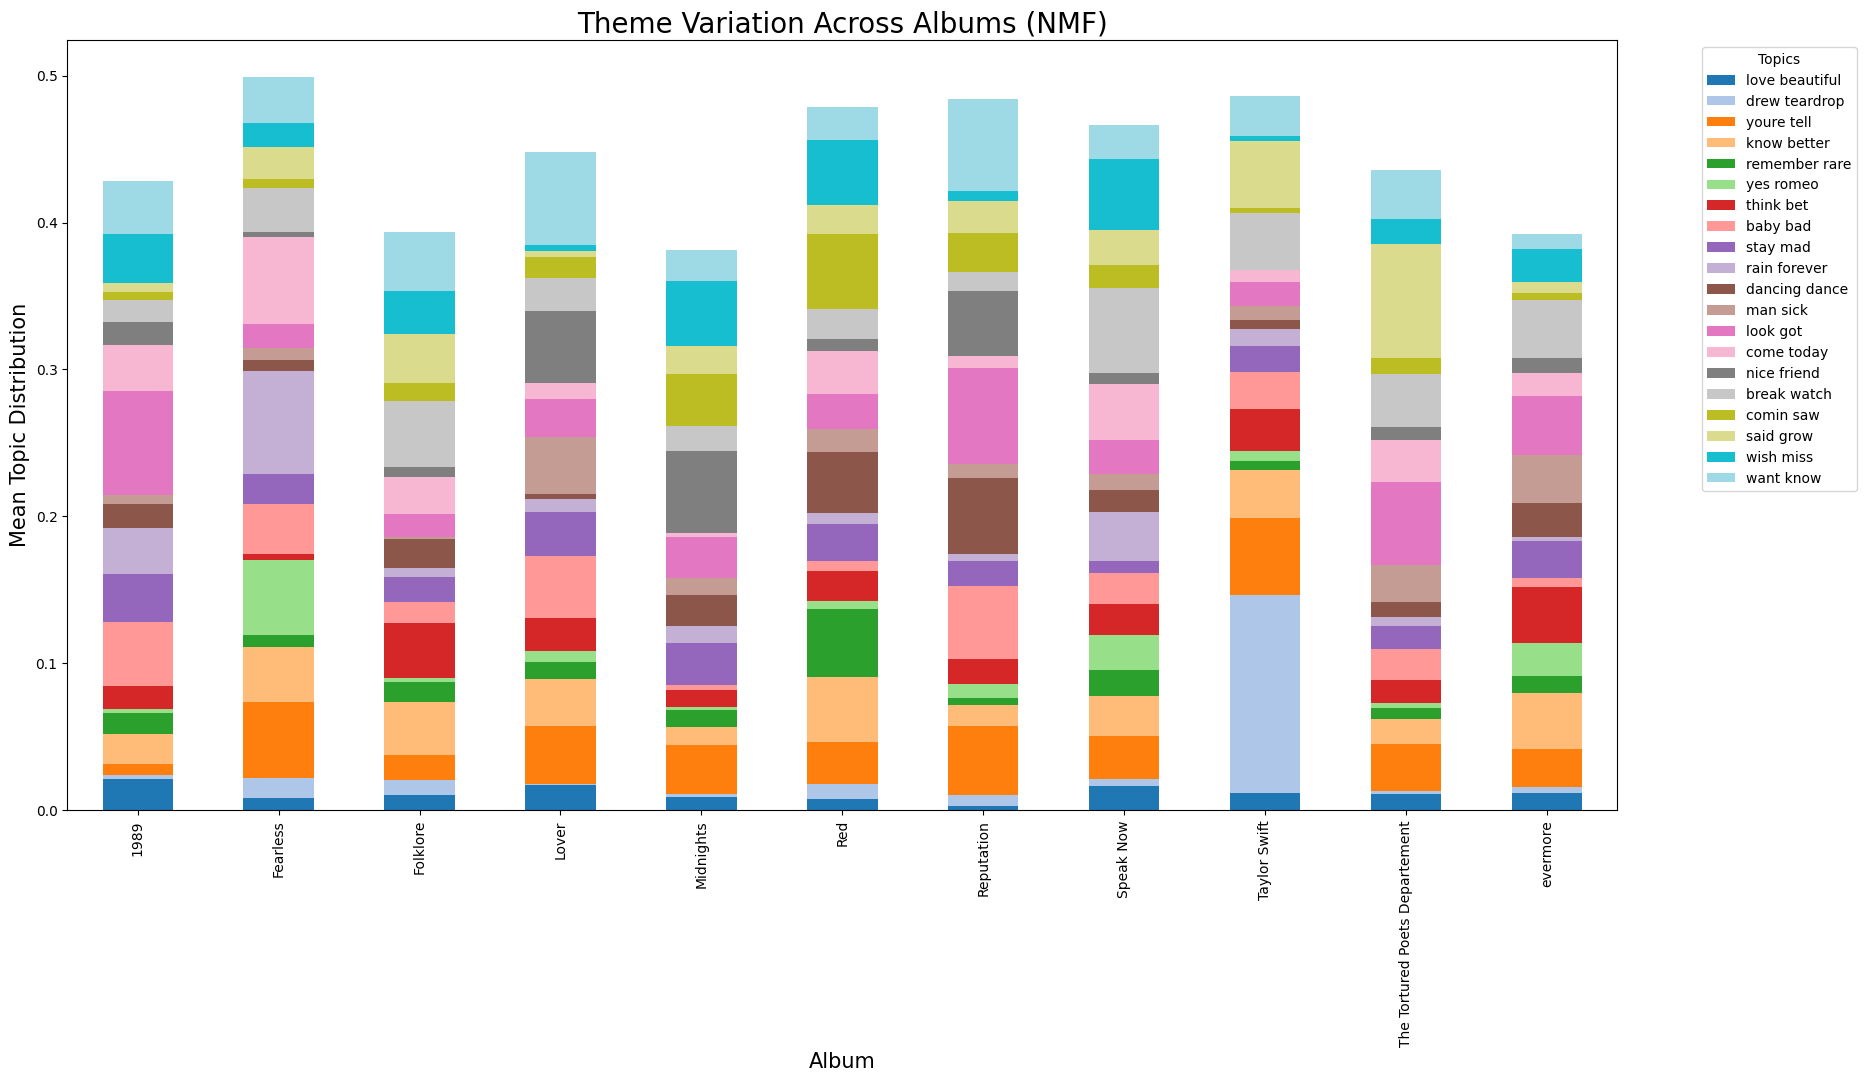

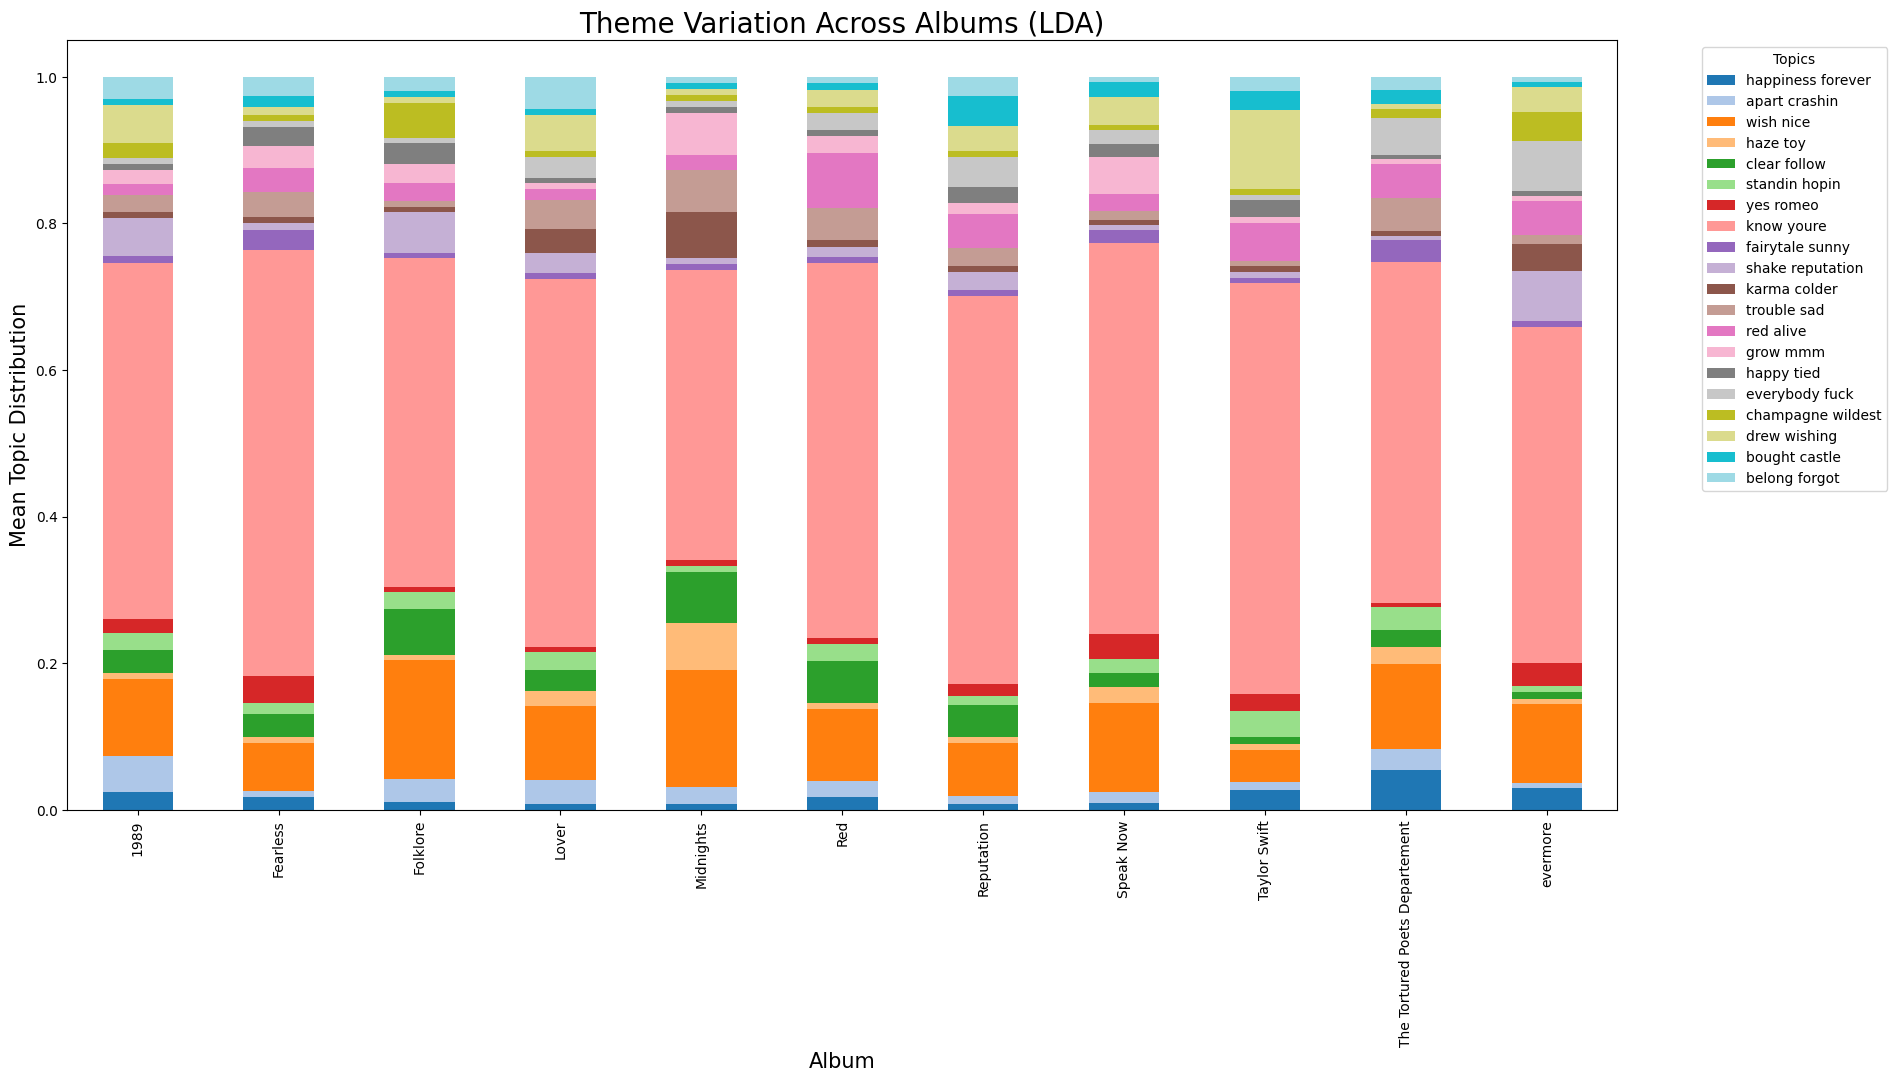

In [11]:
# Analyze theme variation across different albums
merged_df_nmf = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(nmf_topics, columns=nmf_topic_names)], axis=1)
merged_df_lda = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(lda_topics, columns=lda_topic_names)], axis=1)

# Ensure only numeric columns are considered
numeric_columns_nmf = merged_df_nmf.select_dtypes(include=[np.number]).columns
numeric_columns_lda = merged_df_lda.select_dtypes(include=[np.number]).columns

# Group by album and calculate mean topic distribution
album_nmf_distribution = merged_df_nmf.groupby('Album')[numeric_columns_nmf].mean().iloc[:, -20:]
album_lda_distribution = merged_df_lda.groupby('Album')[numeric_columns_lda].mean().iloc[:, -20:]

# Plotting theme variation across albums
def plot_theme_variation(album_distribution, model_name):
    album_distribution.plot(kind='bar', stacked=True, figsize=(20, 10), colormap='tab20')
    plt.title(f'Theme Variation Across Albums ({model_name})', fontsize=20)
    plt.xlabel('Album', fontsize=15)
    plt.ylabel('Mean Topic Distribution', fontsize=15)
    plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_theme_variation(album_nmf_distribution, 'NMF')
plot_theme_variation(album_lda_distribution, 'LDA')

Topic 1 (NMF): m know want
Topic 2 (NMF): ooh run getting
Topic 3 (NMF): oh come sorry
Topic 4 (NMF): na wan gon
Topic 5 (NMF): ah ha finally
Topic 6 (NMF): s drew guitar
Topic 7 (NMF): n t ca
Topic 8 (NMF): love comin grace
Topic 9 (NMF): said rain baby
Topic 10 (NMF): d man remember
Topic 1 (LDA): lucky everybody welcome
Topic 2 (LDA): florida happiness innocent
Topic 3 (LDA): forgot mr tied
Topic 4 (LDA): dear polish ruining
Topic 5 (LDA): shake grow romeo
Topic 6 (LDA): oh m s
Topic 7 (LDA): da promise grow
Topic 8 (LDA): karma fuck stayed
Topic 9 (LDA): castle afraid revenge
Topic 10 (LDA): guitar drew break


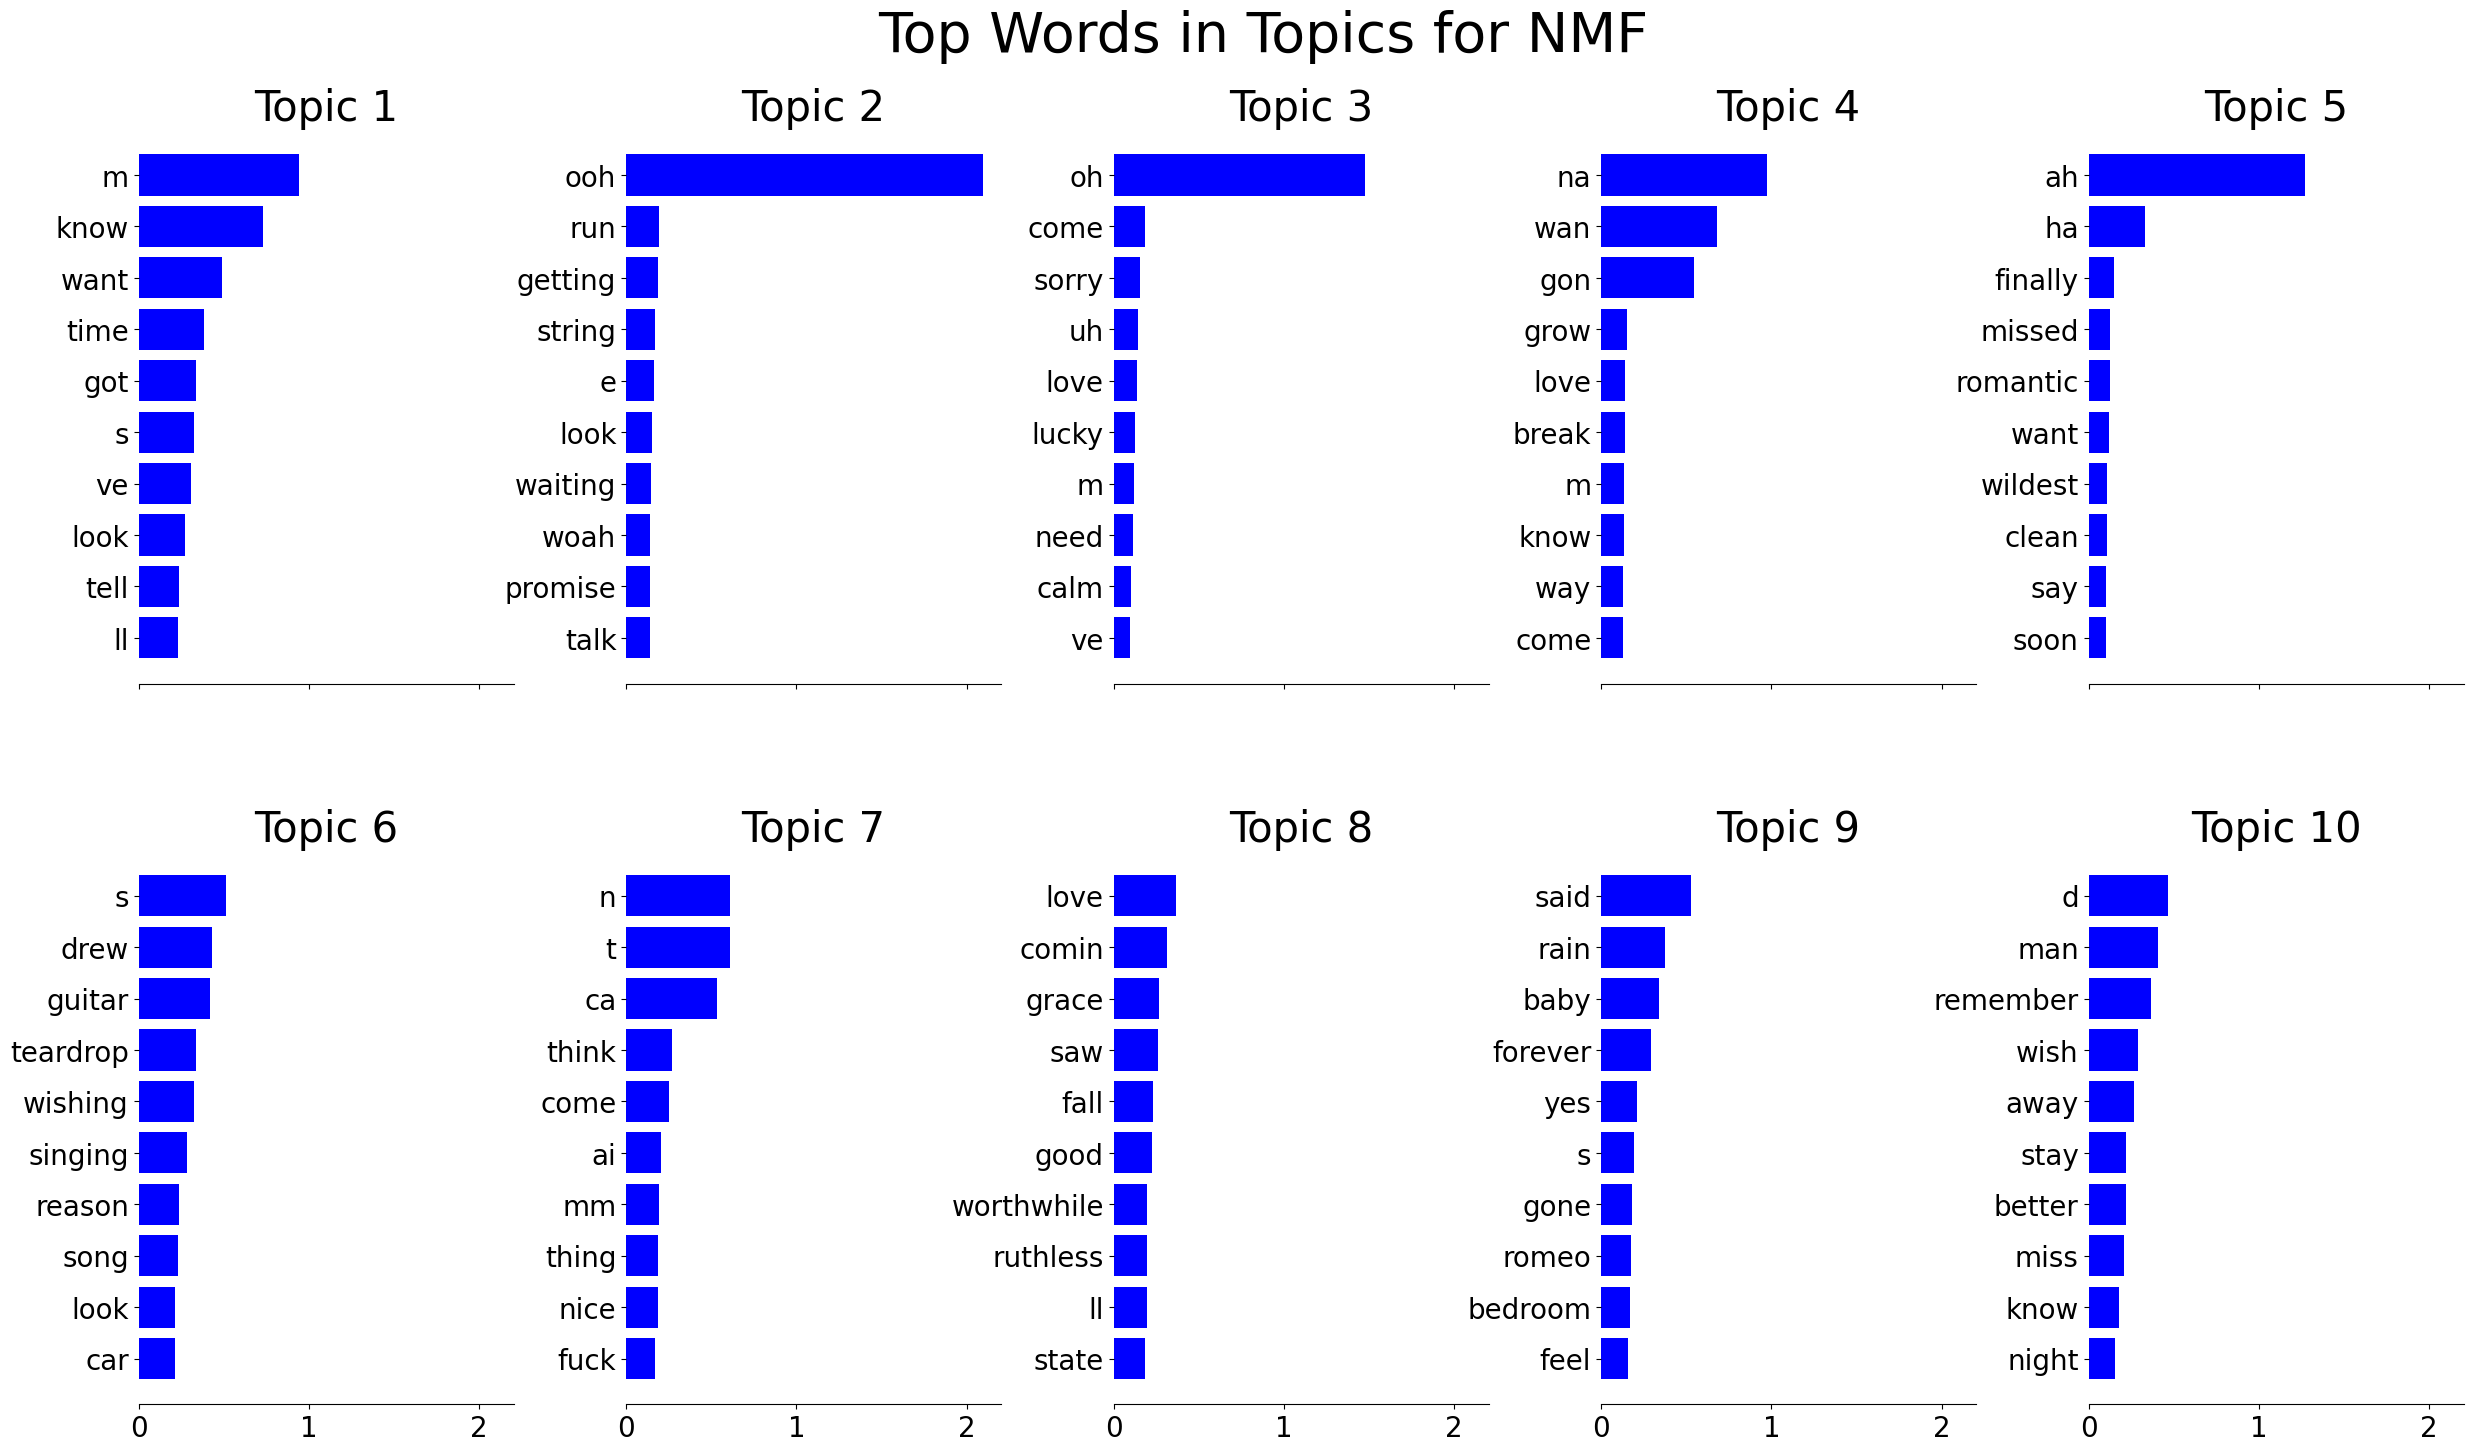

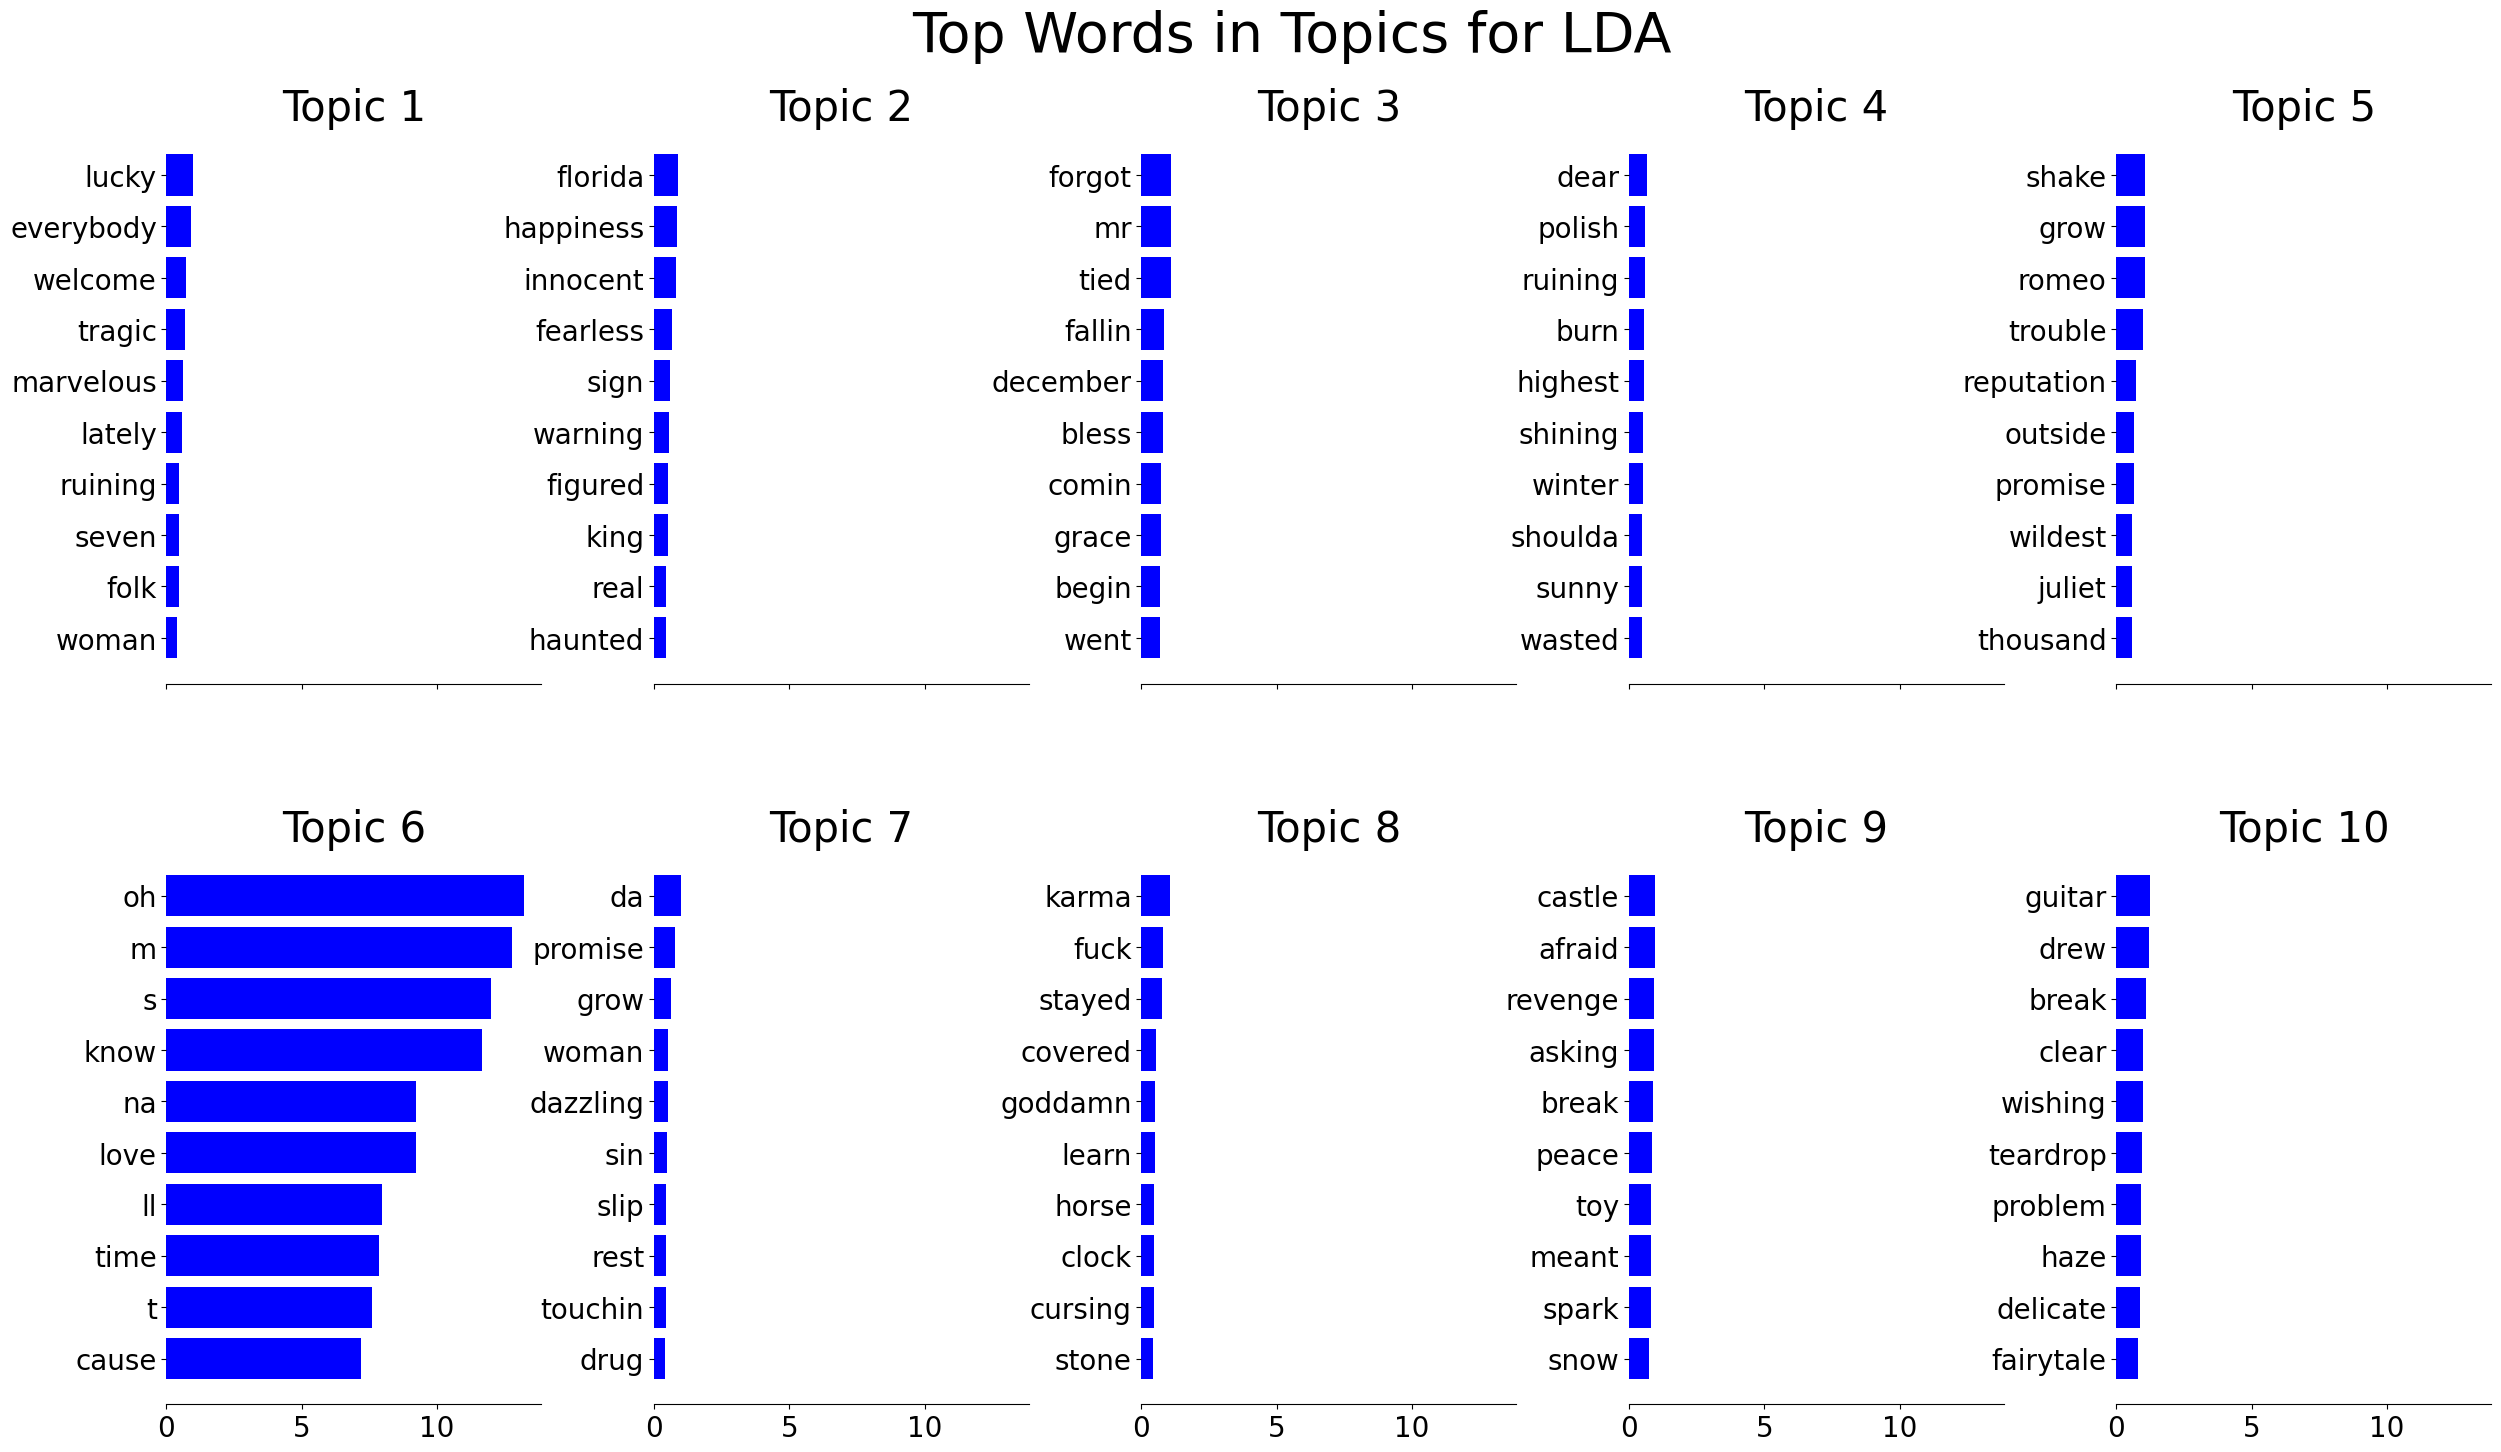

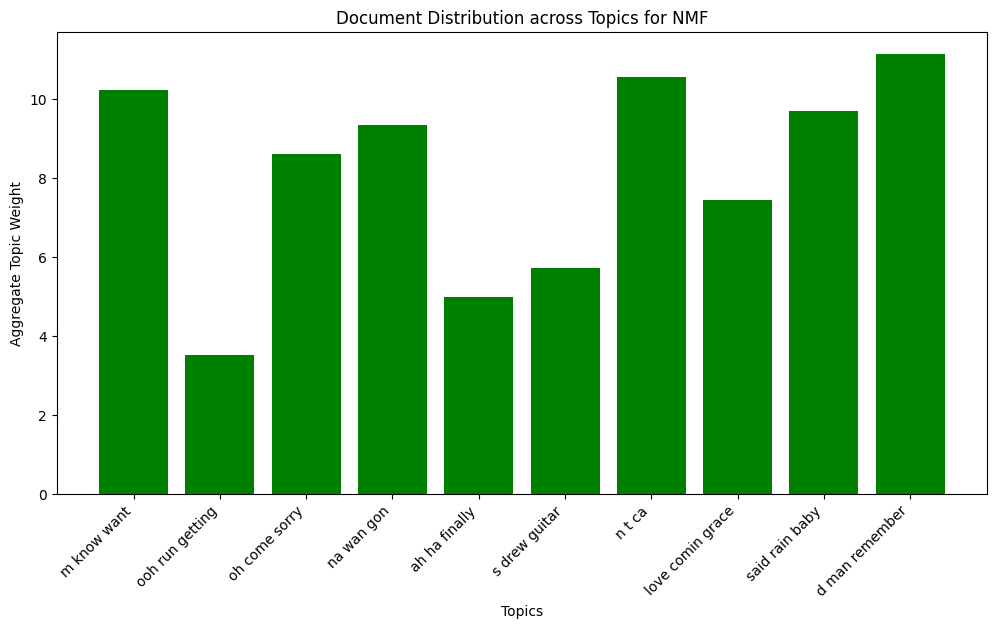

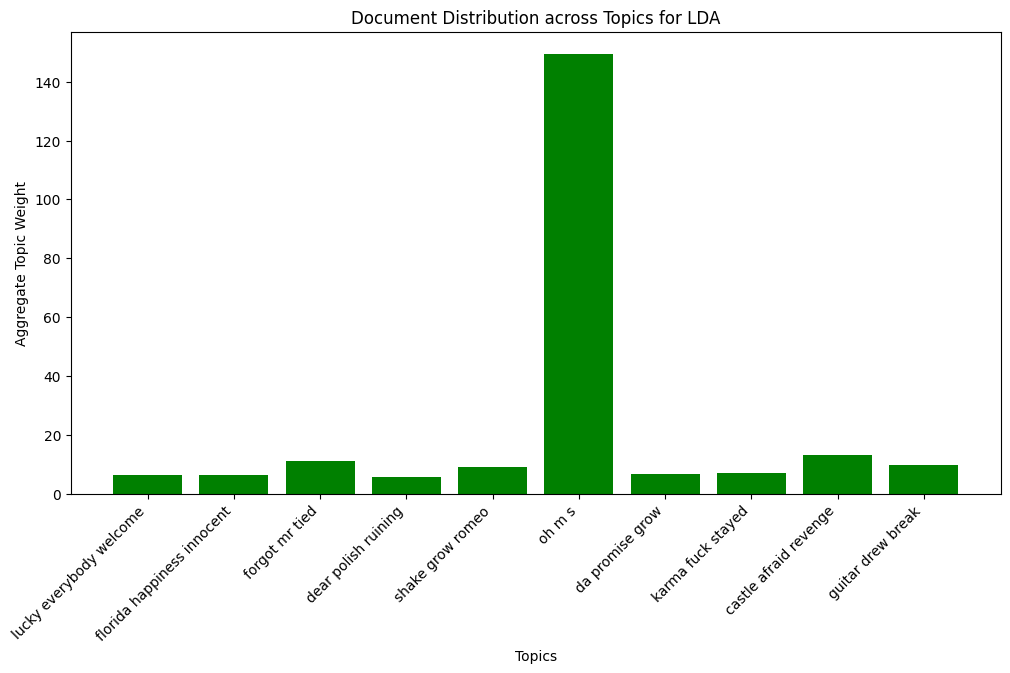

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Assuming tfidf_matrix and tfidf_vectorizer are already defined and fit
# tfidf_matrix = ...
# tfidf_vectorizer = ...

# Topic Modeling - NMF
nmf_model = NMF(n_components=10, random_state=42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

# Topic Modeling - LDA
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_matrix)

# Get the feature names (terms) from the TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to extract and print the top words for each topic
def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_name = " ".join(top_features[:3])  # Using top 3 words for naming
        topic_names.append(topic_name)
    return topic_names

nmf_topic_names = get_topic_names(nmf_model, tfidf_feature_names, 10)
lda_topic_names = get_topic_names(lda_model, tfidf_feature_names, 10)

for idx, topic_name in enumerate(nmf_topic_names):
    print(f"Topic {idx+1} (NMF): {topic_name}")

for idx, topic_name in enumerate(lda_topic_names):
    print(f"Topic {idx+1} (LDA): {topic_name}")

# Visualizing the Top Words for Each Topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(int(np.ceil(model.n_components / 5)), 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx+1}', fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, hspace=0.3, wspace=0.3)
    plt.show()

plot_top_words(nmf_model, tfidf_feature_names, 10, 'Top Words in Topics for NMF')
plot_top_words(lda_model, tfidf_feature_names, 10, 'Top Words in Topics for LDA')

# Visualizing Document Distribution Over Topics
def plot_document_topics(model_output, topic_names, title):
    topic_distribution = np.sum(model_output, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.bar(topic_names, topic_distribution, color='green')
    plt.xlabel('Topics')
    plt.ylabel('Aggregate Topic Weight')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_document_topics(nmf_topics, nmf_topic_names, 'Document Distribution across Topics for NMF')
plot_document_topics(lda_topics, lda_topic_names, 'Document Distribution across Topics for LDA')


In [8]:
y_album = merged_df['Album']
y_year = merged_df['Year']

# Combine NMF and LDA features
X_combined = np.hstack((nmf_topics, lda_topics))

# Encode the target variables
label_encoder_album = LabelEncoder()
label_encoder_year = LabelEncoder()
y_album_encoded = label_encoder_album.fit_transform(y_album)
y_year_encoded = label_encoder_year.fit_transform(y_year)

# Balance the classes using SMOTE
smote = SMOTE(random_state=42)
X_combined_balanced, y_album_balanced = smote.fit_resample(X_combined, y_album_encoded)

# Applying PCA to the balanced datasets
pca = PCA(n_components=20, random_state=42)
X_combined_pca = pca.fit_transform(X_combined_balanced)

# Train-test split with stratification
X_train_combined, X_test_combined, y_train_album, y_test_album = train_test_split(X_combined_pca, y_album_balanced, test_size=0.2, random_state=42, stratify=y_album_balanced)

# Random Forest for Album Prediction
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_combined, y_train_album)
best_rf_model = rf_grid_search.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test_combined)

# Decode the predictions back to original labels
y_pred_rf_decoded = label_encoder_album.inverse_transform(y_pred_rf)

# Evaluate the Random Forest model performance
def evaluate_model(y_true, y_pred, task_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"Performance metrics for {task_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}\n")

evaluate_model(y_test_album, y_pred_rf, 'Album Prediction (Combined NMF+LDA) with Random Forest')

# Combine NMF and LDA features for year prediction
X_combined_year = np.hstack((nmf_topics, lda_topics))

# Balance the classes using SMOTE for year prediction
X_combined_year_balanced, y_year_balanced = smote.fit_resample(X_combined_year, y_year_encoded)

# Applying PCA to the balanced datasets for year prediction
X_combined_year_pca = pca.fit_transform(X_combined_year_balanced)

# Train-test split with stratification for year prediction
X_train_combined_year, X_test_combined_year, y_train_year, y_test_year = train_test_split(X_combined_year_pca, y_year_balanced, test_size=0.2, random_state=42, stratify=y_year_balanced)

# Random Forest for Year Prediction
rf_grid_search_year = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search_year.fit(X_train_combined_year, y_train_year)
best_rf_model_year = rf_grid_search_year.best_estimator_

# Predicting with the best Random Forest model for year
y_pred_rf_year = best_rf_model_year.predict(X_test_combined_year)

# Decode the predictions back to original labels for year
y_pred_rf_year_decoded = label_encoder_year.inverse_transform(y_pred_rf_year)

# Evaluate the Random Forest model performance for year
evaluate_model(y_test_year, y_pred_rf_year, 'Year Prediction (Combined NMF+LDA) with Random Forest')

# Example: Adding a thematic category column
thematic_categories = {
    'Fearless': 'Love',
    '1989': 'Heartbreak',
    'Red': 'Relationships',
    'Lover': 'Happiness',
    'Folklore': 'Melancholy',
    'Evermore': 'Nostalgia',
    'Reputation': 'Revenge',
    'Midnights': 'Introspection',
    'Taylor Swift': 'Coming of Age',
    'Speak Now': 'Growth'
}

# Map thematic categories to each album
merged_df['Thematic_Category'] = merged_df['Album'].map(thematic_categories)

# Encode the target variable for thematic category
label_encoder_thematic_category = LabelEncoder()
y_thematic_category = merged_df['Thematic_Category']
y_thematic_category_encoded = label_encoder_thematic_category.fit_transform(y_thematic_category)

# Balance the classes using SMOTE
X_combined_thematic_balanced, y_thematic_balanced = smote.fit_resample(X_combined, y_thematic_category_encoded)

# Applying PCA to the balanced datasets
X_combined_thematic_pca = pca.fit_transform(X_combined_thematic_balanced)

# Train-test split with stratification
X_train_combined_thematic, X_test_combined_thematic, y_train_thematic, y_test_thematic = train_test_split(X_combined_thematic_pca, y_thematic_balanced, test_size=0.2, random_state=42, stratify=y_thematic_balanced)

# Random Forest for Thematic Category Prediction
rf_grid_search_thematic = GridSearchCV(rf_clf, rf_param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy', n_jobs=-1)
rf_grid_search_thematic.fit(X_train_combined_thematic, y_train_thematic)
best_rf_model_thematic = rf_grid_search_thematic.best_estimator_

# Predicting with the best Random Forest model
y_pred_rf_thematic = best_rf_model_thematic.predict(X_test_combined_thematic)

# Decode the predictions back to original labels
y_pred_rf_thematic_decoded = label_encoder_thematic_category.inverse_transform(y_pred_rf_thematic)

# Evaluate the Random Forest model performance
evaluate_model(y_test_thematic, y_pred_rf_thematic, 'Thematic Category Prediction (Combined NMF+LDA) with Random Forest')

def predict_album_from_lyrics(lyrics):
    # Preprocess lyrics
    lyrics_cleaned = clean_lyrics(lyrics)
    lyrics_no_stopwords = remove_stopwords(lyrics_cleaned)
    lyrics_processed = tokenize_and_lemmatize(lyrics_no_stopwords)
    
    # Extract features
    nmf_topics_lyrics = nmf_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    lda_topics_lyrics = lda_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    combined_topics_lyrics = np.hstack((nmf_topics_lyrics, lda_topics_lyrics))
    
    # Apply PCA
    combined_topics_pca_lyrics = pca.transform(combined_topics_lyrics)
    
    # Predict the album using the trained model
    predicted_album_encoded = best_rf_model.predict(combined_topics_pca_lyrics)
    predicted_album = label_encoder_album.inverse_transform(predicted_album_encoded)
    
    print(f"The predicted album for the given lyrics is: {predicted_album[0]}")

def predict_year_from_album(album_name):
    # Find the album in the dataset
    album_data = merged_df[merged_df['Album'] == album_name]
    
    if album_data.empty:
        print("Album not found in the dataset.")
        return
    
    # Combine NMF and LDA features
    album_nmf_topics = nmf_model.transform(tfidf_vectorizer.transform(album_data['processed_lyrics']))
    album_lda_topics = lda_model.transform(tfidf_vectorizer.transform(album_data['processed_lyrics']))
    album_combined_topics = np.hstack((album_nmf_topics, album_lda_topics))
    
    # Apply PCA
    album_combined_pca = pca.transform(album_combined_topics)
    
    # Predict the year using the trained model
    predicted_year_encoded = best_rf_model_year.predict(album_combined_pca)
    predicted_year = label_encoder_year.inverse_transform(predicted_year_encoded)
    
    print(f"The predicted release year for the album '{album_name}' is: {predicted_year[0]}")

def predict_thematic_category_from_lyrics(lyrics):
    # Preprocess lyrics
    lyrics_cleaned = clean_lyrics(lyrics)
    lyrics_no_stopwords = remove_stopwords(lyrics_cleaned)
    lyrics_processed = tokenize_and_lemmatize(lyrics_no_stopwords)
    
    # Extract features
    nmf_topics_lyrics = nmf_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    lda_topics_lyrics = lda_model.transform(tfidf_vectorizer.transform([lyrics_processed]))
    combined_topics_lyrics = np.hstack((nmf_topics_lyrics, lda_topics_lyrics))
    
    # Apply PCA
    combined_topics_pca_lyrics = pca.transform(combined_topics_lyrics)
    
    # Predict the thematic category using the trained model
    predicted_thematic_encoded = best_rf_model_thematic.predict(combined_topics_pca_lyrics)
    predicted_thematic = label_encoder_thematic_category.inverse_transform(predicted_thematic_encoded)
    
    print(f"The predicted thematic category for the given lyrics is: {predicted_thematic[0]}")

# Test the functions
predict_album_from_lyrics("We were both young when I first saw you...")
predict_year_from_album("Fearless")
predict_thematic_category_from_lyrics("We were both young when I first saw you...")

NameError: name 'SMOTE' is not defined

In [ ]:
merged_df['target'] = np.random.randint(0, 2, merged_df.shape[0])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, merged_df['target'], test_size=0.2, random_state=42)

In [ ]:
# Initialize and train a logistic regression model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train, y_train)

# Support Vector Machine
#model_svc = SVC(kernel='linear')
#model_svc.fit(X_train, y_train)

In [ ]:
y_pred = model_rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Reduce the TF-IDF features to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df)

# Plot the reduced features
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['target'])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('TF-IDF Features PCA Projection')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# Assuming merged_df and tfidf_df are already defined

# 1. Basic Statistics and Summary
print("Dataset Info:\n", merged_df.info())
print("\nBasic Statistics:\n", merged_df.describe())
print("\nMissing Values:\n", merged_df.isna().sum())

# 2. Distribution of TF-IDF Features
# Get basic statistics for TF-IDF DataFrame
print("\nTF-IDF DataFrame Info:\n", tfidf_df.info())
print("\nTF-IDF DataFrame Basic Statistics:\n", tfidf_df.describe())

# Plot distribution of a few TF-IDF features
tfidf_sample = tfidf_df.sample(5, axis=1)
tfidf_sample.hist(bins=50, figsize=(20, 15))
plt.suptitle("Distribution of Sample TF-IDF Features")
plt.show()

# 3. Visualization with PCA and t-SNE
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df.dropna())

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=merged_df['target'], cmap='viridis')
plt.title('PCA Projection of TF-IDF Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Target')
plt.show()

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(tfidf_df.dropna())

plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=merged_df['target'], cmap='viridis')
plt.title('t-SNE Projection of TF-IDF Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Target')
plt.show()

# 4. Word Cloud of Lyrics
all_lyrics = ' '.join(merged_df['lyrics'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lyrics)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lyrics')
plt.show()

# 5. Correlation Analysis (if applicable)
# Compute pairwise correlation of TF-IDF features
correlation_matrix = tfidf_df.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmax=0.3, center=0, square=True, linewidths=0.5)
plt.title('Heatmap of TF-IDF Features Correlation')
plt.show()
